In [99]:
library(mgcv)
library(readxl)
library(ggplot2)
library(dplyr)
library(tibble)
library(lubridate)
library(tidyr)
library(purrr)
library(marginaleffects)
library(readr)
library(geosphere)
library(gratia)
library(qs2)

options(repr.plot.width=15, repr.plot.height=8)
options('marginaleffects_posterior_interval' = 'hdi')

# Start and end dates for Active Streets Trial
AST = c(as.Date("2023-08-03"), as.Date("2024-07-24"))

# School Holidays
SCHOOL_HOL = list(
                interval(as.Date("2022-10-24"), as.Date("2022-10-28")),
                interval(as.Date("2022-12-19"), as.Date("2023-01-02")),
                interval(as.Date("2023-02-13"), as.Date("2023-02-17")),
                interval(as.Date("2023-04-03"), as.Date("2023-04-14")),
                interval(as.Date("2023-05-01"), as.Date("2023-05-01")),
                interval(as.Date("2023-05-29"), as.Date("2023-06-02")),
                interval(as.Date("2023-07-26"), as.Date("2023-09-01")),
                interval(as.Date("2023-10-23"), as.Date("2023-10-27")),
                interval(as.Date("2023-12-18"), as.Date("2024-01-01")),
                interval(as.Date("2024-02-12"), as.Date("2024-02-16")),
                interval(as.Date("2024-03-29"), as.Date("2024-04-12")),
                interval(as.Date("2024-05-06"), as.Date("2024-05-06")),
                interval(as.Date("2024-05-27"), as.Date("2024-05-31")),
                interval(as.Date("2024-07-29"), as.Date("2024-09-02")),
                interval(as.Date("2024-10-28"), as.Date("2024-11-01")),
                interval(as.Date("2024-12-23"), as.Date("2025-01-03"))
)

# Bank Holidays: https://www.gov.uk/bank-holidays
BANK_HOLS = list(interval(as.Date("2022-09-19"), as.Date("2022-09-19")),
                interval(as.Date("2022-12-26"), as.Date("2022-12-27")),
                interval(as.Date("2023-01-02"), as.Date("2023-01-02")),
                interval(as.Date("2023-04-07"), as.Date("2023-04-10")),
                interval(as.Date("2023-05-01"), as.Date("2023-05-01")),
                interval(as.Date("2023-05-08"), as.Date("2023-05-08")),
                interval(as.Date("2023-05-29"), as.Date("2023-05-29")),
                interval(as.Date("2023-08-28"), as.Date("2023-08-28")),
                interval(as.Date("2023-12-25"), as.Date("2023-12-26")),
                interval(as.Date("2024-01-01"), as.Date("2024-01-01")),
                interval(as.Date("2024-03-29"), as.Date("2024-04-01")),
                interval(as.Date("2024-05-06"), as.Date("2024-05-06")),
                interval(as.Date("2024-05-27"), as.Date("2024-05-27")),
                interval(as.Date("2024-08-26"), as.Date("2024-08-26")),
                interval(as.Date("2024-12-25"), as.Date("2024-12-26"))
                )

# British Summer Time dates
BST = list(interval(as.Date("2022-03-27"), as.Date("2022-10-30")),
            interval(as.Date("2023-03-26"), as.Date("2023-10-29")),
            interval(as.Date("2024-03-31"), as.Date("2024-10-27"))
            )

# Load rainfall data
tp <- read_delim(file = 'data/exeter_rainfall.csv', delim=' ', show_col_types = FALSE) %>% 
       select(date, value) %>%
       rename(Date = date, rain = value) %>%
       mutate(rain = rain*1e3) %>% # Convert rainfall total to mm
       replace(is.na(.), 0)

ERROR: Error in library(qs2): there is no package called ‘qs2’


In [67]:
# Supplementary Data 2022-2024: Sensors 2022-2024.xlsx
lsr_names = c("Ladysmith Rd 22", 
            "Ladysmith Rd 23",
            "Ladysmith Rd 24")

pr_names = c("Park Rd 22", 
            "Park Rd 23",
            "Park Road 24")

hl_names = c("Hamlin Ln 22", 
            "Hamlin Ln 23",
            "Hamlin Ln 24")

rc_names = c("Roseland Cres 22", 
            "Roseland Cres 23",
            "Roseland Cres 24")

vr_names = c("Vaughan Rd 22", 
            "Vaughan Rd 23",
            "Vaughan Rd 24")
 
 tr_names = c("Thornpark Rs 22", 
            "Thornpark Rs 23",
            "Thornpark Rs 24",
            "Tpark Rs LHS 22",
            "Tpark Rs LHS 23",
            "Tpark Rs LHS 24",
            "Tpark Rs RHS 22",
            "Tpark Rs RHS 23",
            "Tpark Rs RHS 24")

sheets <- list("Ladysmith Road"=lsr_names, 
                  "Park Road"=pr_names, 
                  "Hamlin Lane"=hl_names, 
                  "Roseland Crescent"=rc_names, 
                  "Vaughan Road"=vr_names, 
                  "Thornpark Road"=tr_names
              )

df2 <- purrr::map_dfr(names(sheets), function(x){
       df <- bind_rows(lapply(sheets[[x]], FUN = read_excel, path="./data/Sensors 2022-2024.xlsx"))
       df %>% mutate(Date = as.Date(`Local Datetime`), location=as.factor(x), mode="Cyclist") %>%
       select(-c(`UTC Datetime`, `Local Datetime`, countlineName, direction)) %>%
       rename(count=Cyclist)
})


In [68]:
# Supplementary Data 2022-2024: Sensors 2022-2024.xlsx
atc11 = c("Site 11 22", 
          "Site 11 23",
          "Site 11 24")

atc34 = c("Site 34 22", 
          "Site 34 23",
          "Site 34 24")

atc876 = c("Site 876 22", 
          "Site 876 23",
          "Site 876 24")

atc33 = c("Site 33 22", 
          "Site 33 23",
          "Site 33 24")

atc31 = c("Site 31 22", 
          "Site 31 23",
          "Site 31 24")

atc21 = c("Site 21 22", 
          "Site 21 23",
          "Site 21 24")

atc17 = c("Site 17 22", 
          "Site 17 23",
          "SIte 17 24")  # sic

atc6 = c("Site 6 22", 
          "SIte 6 23",  # sic
          "Site 6 24")

atc3 = c("Site 3 22", 
          "SIte 3 23",  # sic
          "SIte 3 24")  # sic

atc30 = c("Site 30 22", 
          "Site 30 23",
          "Site 30 24")

atc36 = c("Site 36 22", 
          "Site 36 23",
          "Site 36 24")

sheets <- list("Prince Charles Road"=atc11,
"Triangle Car Park"=atc34,
"Hamlin Lane Playing Fields"=atc876,
"Redhayes Bridge"=atc33,
"Haven Banks"=atc31,
"Sowton Digby Railway Link"=atc21,
"Riverside Valley Park"=atc17,
"Rydon Lane North"=atc6,
"Rydon Lane South"=atc3,
"Exminster Canal Causeway"=atc30,
"Exeter Road, Topsham"=atc36)

df3 <- purrr::map_dfr(names(sheets), function(x){
       df <- bind_rows(lapply(sheets[[x]], FUN = read_excel, path="./data/Sensors 2022-2024.xlsx", range="A15:NF39"))
       df %>% pivot_longer(cols=starts_with("20"), values_to = "count", values_drop_na = FALSE, names_to = "Date") %>%
       mutate(location=as.factor(x), mode="Cyclist", Date=as.Date(Date), Time=`...1`) %>%
       select(-c("Workday",	"7 Day", "Count", starts_with("..."))) %>% 
       group_by(Date, location, mode) %>% summarise(count=sum(count, na.rm = TRUE))
       })

New names:
• `` -> `...1`
• `` -> `...370`
New names:
• `` -> `...1`
• `` -> `...370`
New names:
• `` -> `...1`
• `` -> `...315`
• `` -> `...316`
• `` -> `...317`
• `` -> `...318`
• `` -> `...319`
• `` -> `...320`
• `` -> `...321`
• `` -> `...322`
• `` -> `...323`
• `` -> `...324`
• `` -> `...325`
• `` -> `...326`
• `` -> `...327`
• `` -> `...328`
• `` -> `...329`
• `` -> `...330`
• `` -> `...331`
• `` -> `...332`
• `` -> `...333`
• `` -> `...334`
• `` -> `...335`
• `` -> `...336`
• `` -> `...337`
• `` -> `...338`
• `` -> `...339`
• `` -> `...340`
• `` -> `...341`
• `` -> `...342`
• `` -> `...343`
• `` -> `...344`
• `` -> `...345`
• `` -> `...346`
• `` -> `...347`
• `` -> `...348`
• `` -> `...349`
• `` -> `...350`
• `` -> `...351`
• `` -> `...352`
• `` -> `...353`
• `` -> `...354`
• `` -> `...355`
• `` -> `...356`
• `` -> `...357`
• `` -> `...358`
• `` -> `...359`
• `` -> `...360`
• `` -> `...361`
• `` -> `...362`
• `` -> `...363`
• `` -> `...364`
• `` -> `...365`
• `` -> `...366`
• ``

In [71]:
df <- rbind(df2, df3)

In [83]:
df <- rbind(df2, df3) %>%
       mutate(weekday = wday(Date, week_start = 1),
                     Date = as.Date(Date),
                     doy = yday(Date),
                     ast.3bool = case_when(Date < AST[1] ~ as.factor('Before'),
                                          Date <= AST[2] & Date >= AST[1] ~ as.factor('During'), 
                                          Date > AST[2] ~ as.factor('After')),
                     ast.2bool = case_when(Date < AST[1] ~ as.factor('No'),
                                          Date <= AST[2] & Date >= AST[1] ~ as.factor('Yes'), 
                                          Date > AST[2] ~ as.factor('No')),
                     school.hol = as.factor(0),
                     year = year(Date)-min(year(Date)))

# Sum multiple Thornpark Rise sheets
df <- df %>% group_by(Date, location, mode) %>% mutate(count = sum(count)) %>% ungroup() %>% distinct()

# Add school holiday indicator
df <- df %>% mutate(school.hol = if_else(Date %within% SCHOOL_HOL, as.factor(1), as.factor(0))) %>%
       # Add British Summer Time indicator
       mutate(bst.bool = if_else(Date %within% BST, as.factor('BST'), as.factor('UTC'))) %>%
       # Add Length of Day
        mutate(lod = daylength(lat = 50.7290, doy)) %>%
       # Add Bank Holiday indicator
       mutate(bankhol.bool = if_else(Date %within% BANK_HOLS, as.factor(1), as.factor(0))) %>%
       #Add rainfall
       left_join(tp)

Joining with `by = join_by(Date)`


In [74]:
df

count Date       location             mode    weekday doy ast.3bool
1      54   2022-09-09 Ladysmith Road       Cyclist 5       252 Before   
2      57   2022-09-10 Ladysmith Road       Cyclist 6       253 Before   
3      60   2022-09-11 Ladysmith Road       Cyclist 7       254 Before   
4      92   2022-09-12 Ladysmith Road       Cyclist 1       255 Before   
5      81   2022-09-13 Ladysmith Road       Cyclist 2       256 Before   
6     128   2022-09-14 Ladysmith Road       Cyclist 3       257 Before   
7      97   2022-09-15 Ladysmith Road       Cyclist 4       258 Before   
8      92   2022-09-16 Ladysmith Road       Cyclist 5       259 Before   
9      53   2022-09-17 Ladysmith Road       Cyclist 6       260 Before   
10     39   2022-09-18 Ladysmith Road       Cyclist 7       261 Before   
11     42   2022-09-19 Ladysmith Road       Cyclist 1       262 Before   
12    135   2022-09-20 Ladysmith Road       Cyclist 2       263 Before   
13    116   2022-09-21 Ladysmith Road       Cyclist 3       264 Before   
14    152   2022-09-22 Ladysmith Road       Cyclist 4       265 Before   
15    116   2022-09-23 Ladysmith Road       Cyclist 5       266 Before   
16     66   2022-09-24 Ladysmith Road       Cyclist 6       267 Before   
17     59   2022-09-25 Ladysmith Road       Cyclist 7       268 Before   
18    130   2022-09-26 Ladysmith Road       Cyclist 1       269 Before   
19    136   2022-09-27 Ladysmith Road       Cyclist 2       270 Before   
20    113   2022-09-28 Ladysmith Road       Cyclist 3       271 Before   
21    128   2022-09-29 Ladysmith Road       Cyclist 4       272 Before   
22    105   2022-09-30 Ladysmith Road       Cyclist 5       273 Before   
23     67   2022-10-01 Ladysmith Road       Cyclist 6       274 Before   
24     62   2022-10-02 Ladysmith Road       Cyclist 7       275 Before   
25    131   2022-10-03 Ladysmith Road       Cyclist 1       276 Before   
26    137   2022-10-04 Ladysmith Road       Cyclist 2       277 Before   
27    136   2022-10-05 Ladysmith Road       Cyclist 3       278 Before   
28    127   2022-10-06 Ladysmith Road       Cyclist 4       279 Before   
29    138   2022-10-07 Ladysmith Road       Cyclist 5       280 Before   
30     78   2022-10-08 Ladysmith Road       Cyclist 6       281 Before   
⋮     ⋮     ⋮          ⋮                    ⋮       ⋮       ⋮   ⋮        
16113 269   2024-12-02 Exeter Road, Topsham Cyclist 1       337 After    
16114 312   2024-12-03 Exeter Road, Topsham Cyclist 2       338 After    
16115 276   2024-12-04 Exeter Road, Topsham Cyclist 3       339 After    
16116 194   2024-12-05 Exeter Road, Topsham Cyclist 4       340 After    
16117 229   2024-12-06 Exeter Road, Topsham Cyclist 5       341 After    
16118  14   2024-12-07 Exeter Road, Topsham Cyclist 6       342 After    
16119 127   2024-12-08 Exeter Road, Topsham Cyclist 7       343 After    
16120 237   2024-12-09 Exeter Road, Topsham Cyclist 1       344 After    
16121 256   2024-12-10 Exeter Road, Topsham Cyclist 2       345 After    
16122 228   2024-12-11 Exeter Road, Topsham Cyclist 3       346 After    
16123 240   2024-12-12 Exeter Road, Topsham Cyclist 4       347 After    
16124 247   2024-12-13 Exeter Road, Topsham Cyclist 5       348 After    
16125 193   2024-12-14 Exeter Road, Topsham Cyclist 6       349 After    
16126 155   2024-12-15 Exeter Road, Topsham Cyclist 7       350 After    
16127 294   2024-12-16 Exeter Road, Topsham Cyclist 1       351 After    
16128 283   2024-12-17 Exeter Road, Topsham Cyclist 2       352 After    
16129 219   2024-12-18 Exeter Road, Topsham Cyclist 3       353 After    
16130 226   2024-12-19 Exeter Road, Topsham Cyclist 4       354 After    
16131 207   2024-12-20 Exeter Road, Topsham Cyclist 5       355 After    
16132 131   2024-12-21 Exeter Road, Topsham Cyclist 6       356 After    
16133  82   2024-12-22 Exeter Road, Topsham Cyclist 7       357 After    
16134 230   2024-12-23 Exeter Road, Topsham Cyclist 1       358 After    
16135 211 

In [82]:
df.oob <- df %>% group_by(location) %>% summarise(oob = median(count) + 3*var(count)**0.5)
df.oob

location                   oob       
1  Ladysmith Road              197.46379
2  Park Road                   233.56121
3  Hamlin Lane                 189.92956
4  Roseland Crescent           334.88781
5  Vaughan Road                494.42819
6  Thornpark Road              244.05328
7  Prince Charles Road         366.83142
8  Triangle Car Park           164.79773
9  Hamlin Lane Playing Fields  341.85653
10 Redhayes Bridge             336.87293
11 Haven Banks                1951.74497
12 Sowton Digby Railway Link   261.14218
13 Riverside Valley Park      1936.64086
14 Rydon Lane North             89.32915
15 Rydon Lane South            396.01842
16 Exminster Canal Causeway   1165.31769
17 Exeter Road, Topsham        783.70021

In [84]:
df <- df %>% left_join(df.oob) %>% filter(count < oob)

Joining with `by = join_by(location)`


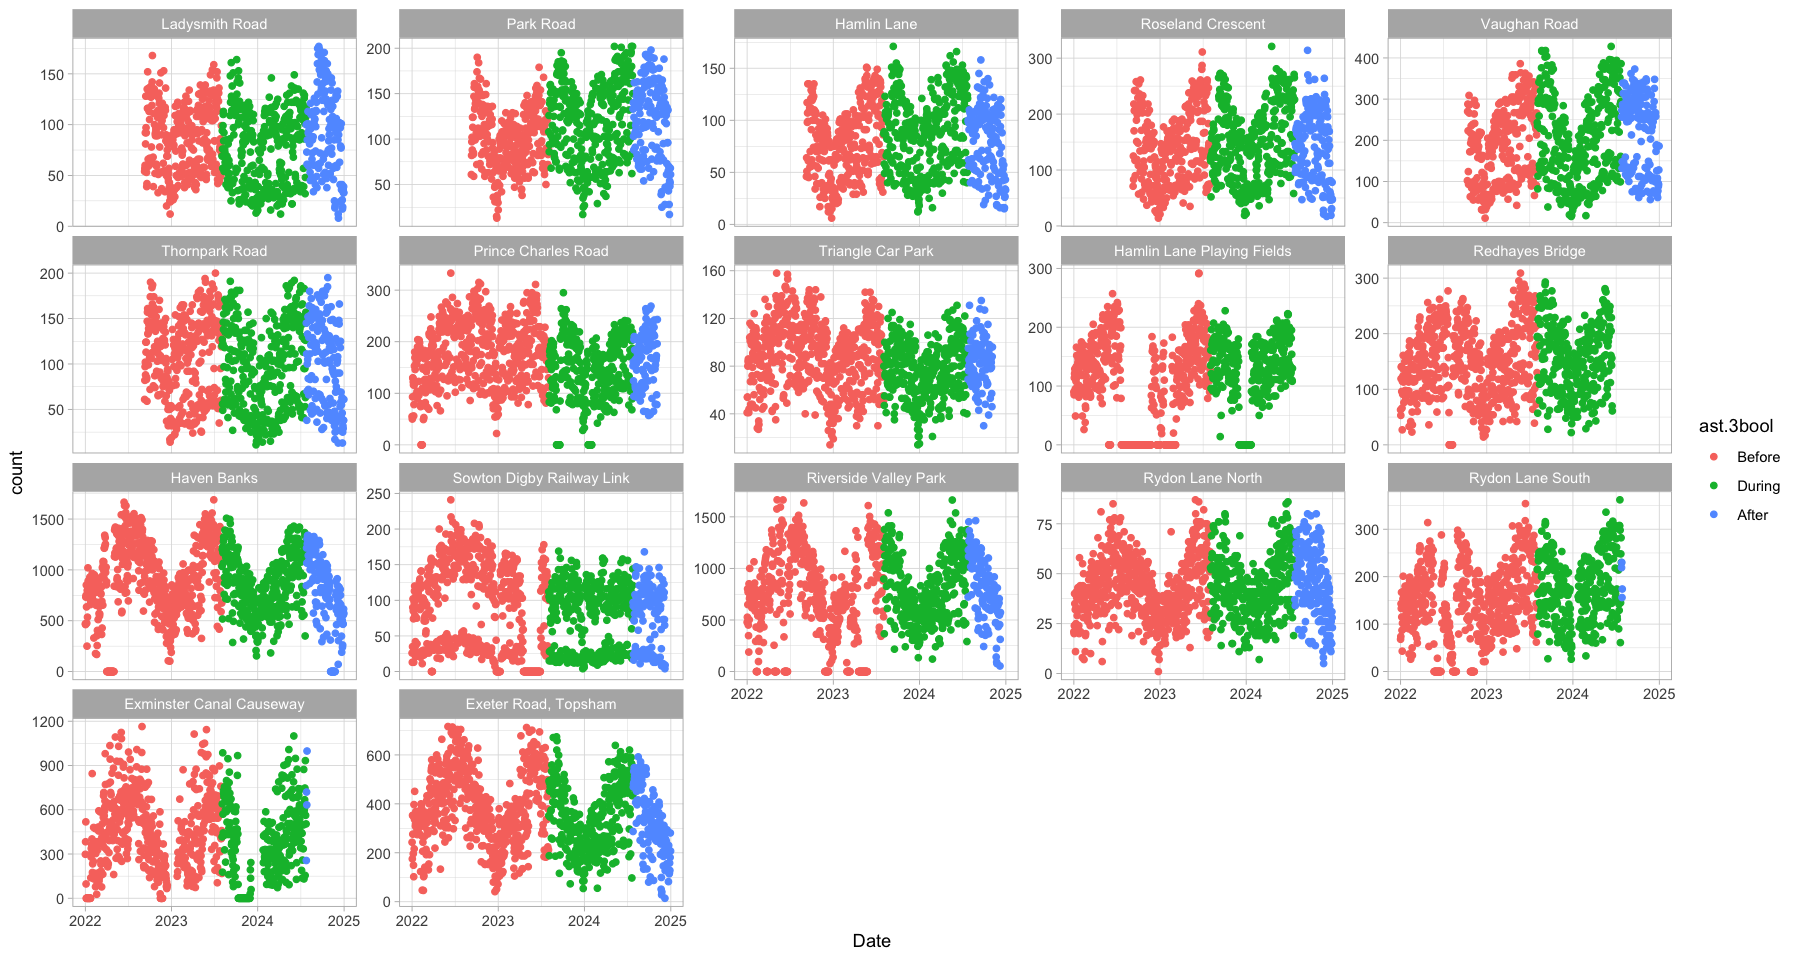

In [86]:
ggplot(data = df %>% filter(mode=='Cyclist'), aes(x=Date, y=count, colour=ast.3bool)) + 
    geom_point() + 
    # annotate("rect", xmin = AST[1], xmax = AST[2], ymin = -1, ymax = 500,
    #          alpha = 0, color= "red") +
    facet_wrap(~location, scales = "free_y") +
    theme_light()

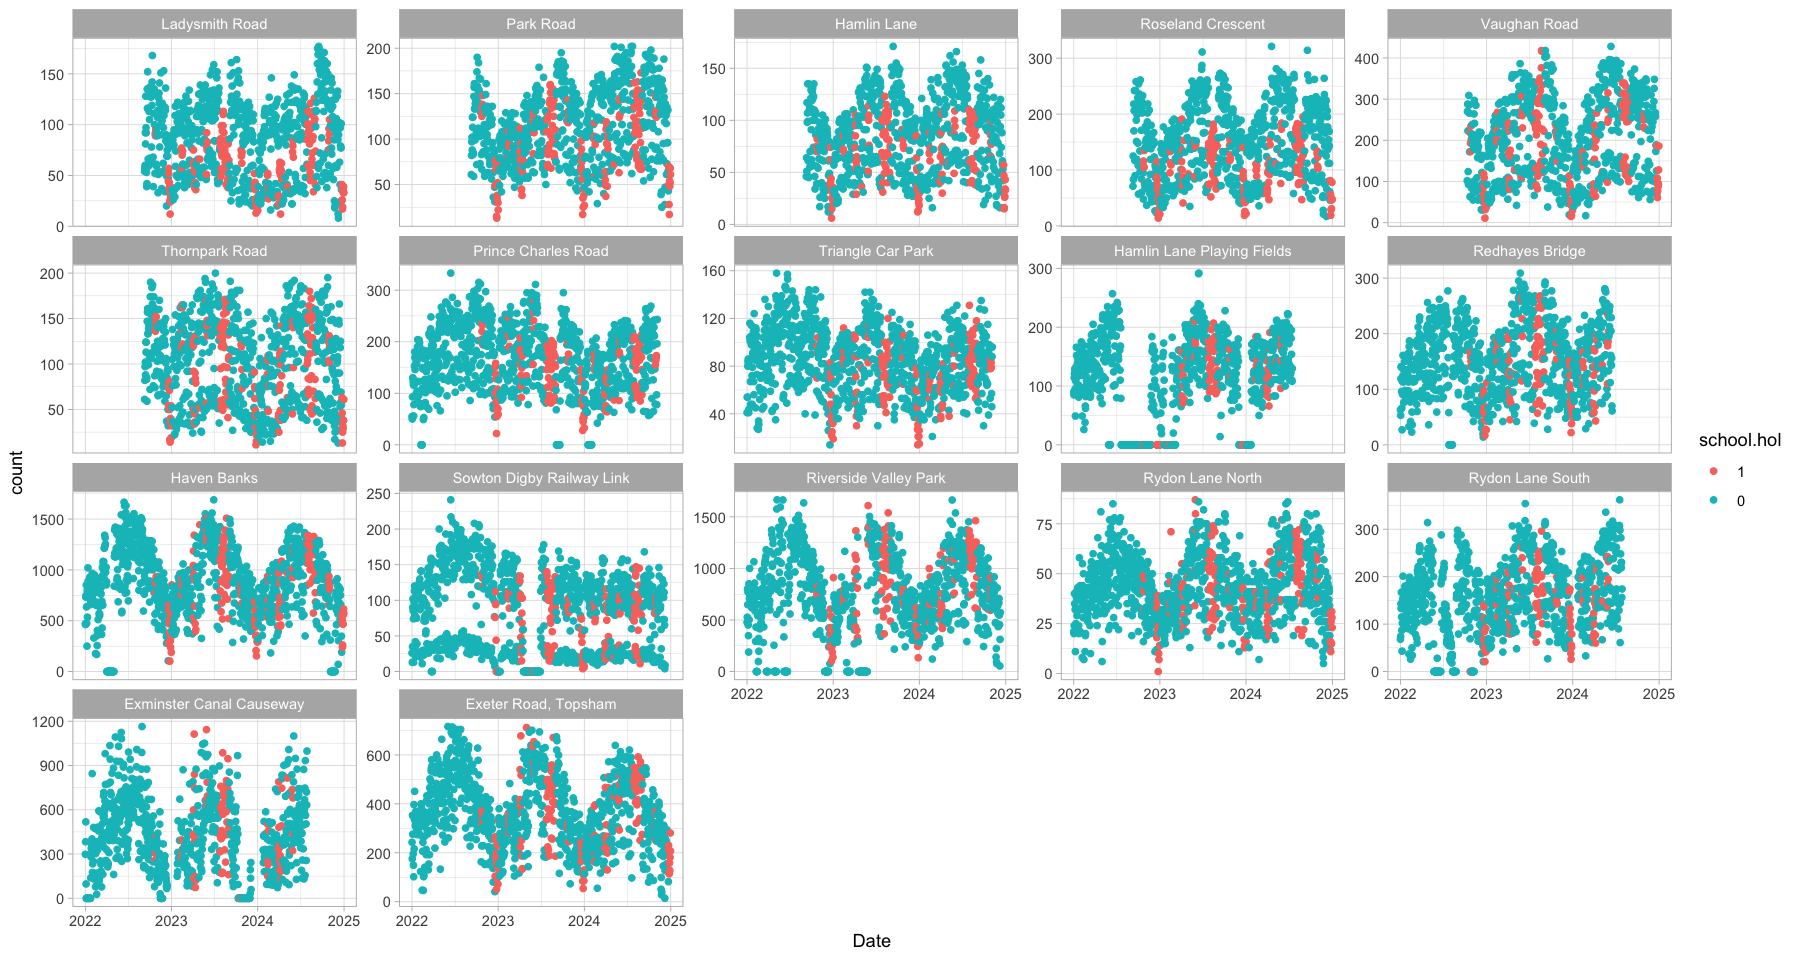

In [89]:
ggplot(data = df %>% filter(mode=='Cyclist'), aes(x=Date, y=count, color=school.hol)) + 
    geom_point() + 
    facet_wrap(~location, scales = "free_y") +
    theme_light()

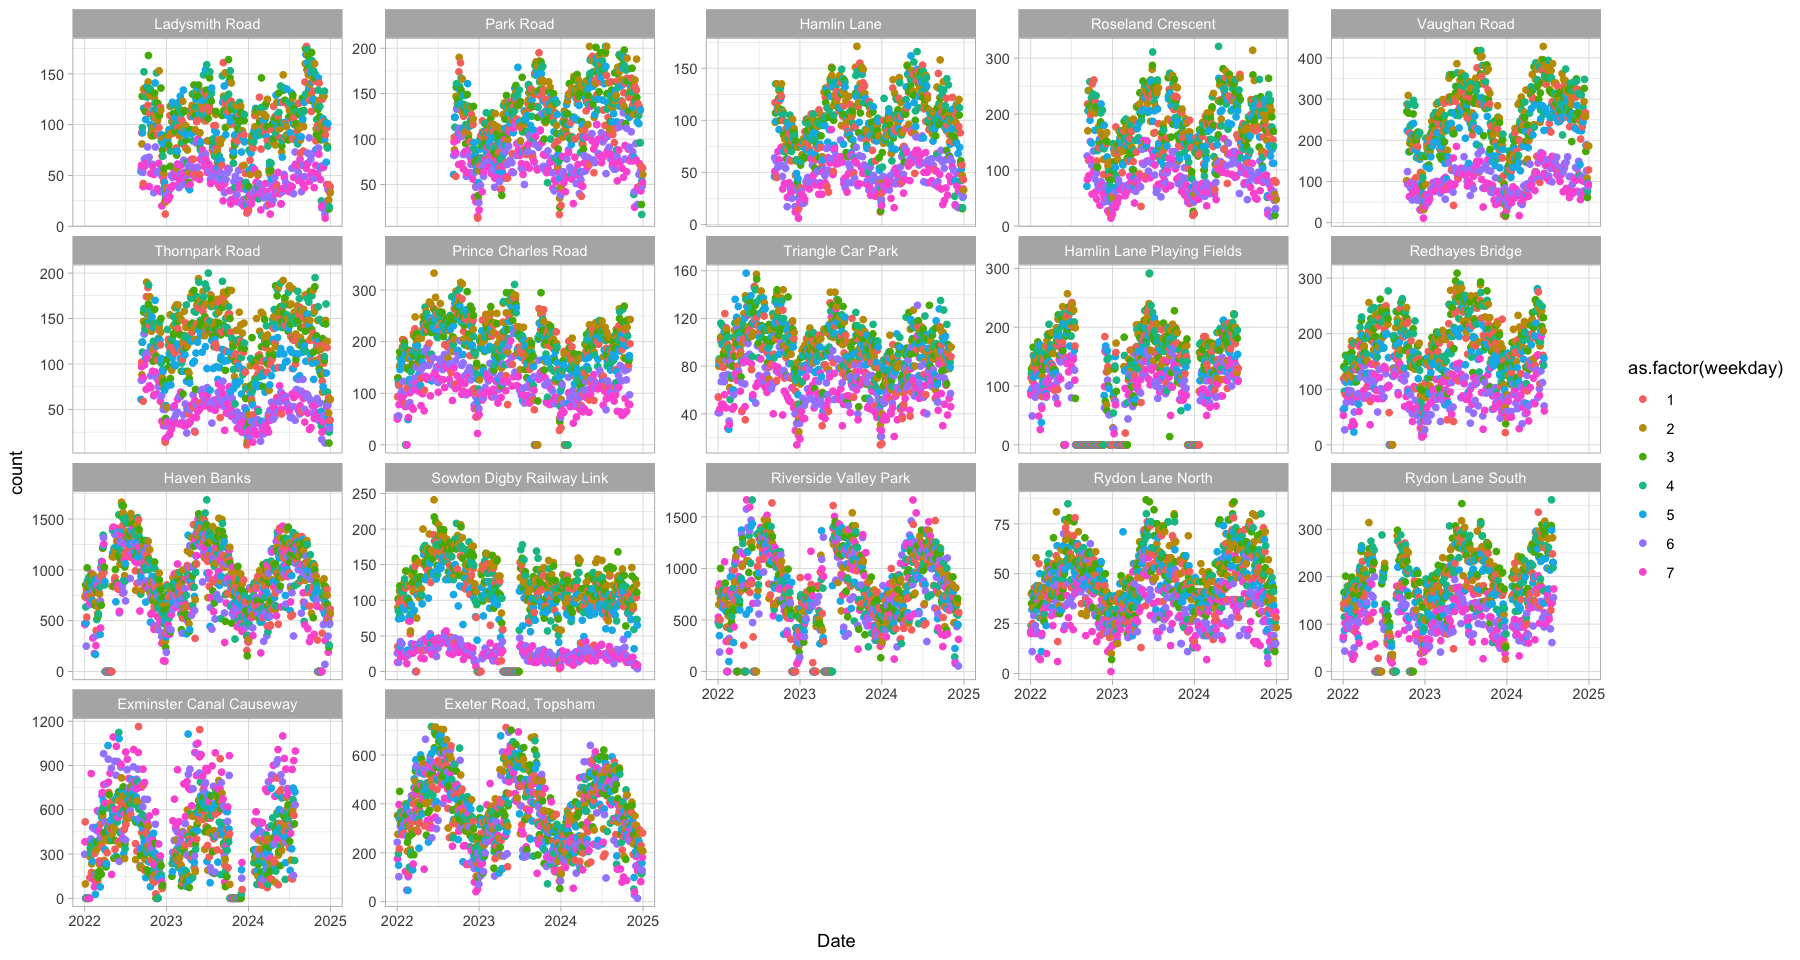

In [91]:
ggplot(data = df %>% filter(mode=='Cyclist'), aes(x=Date, y=count, color=as.factor(weekday))) + 
    geom_point() + 
    facet_wrap(~location, scales = "free_y") +
    theme_light()

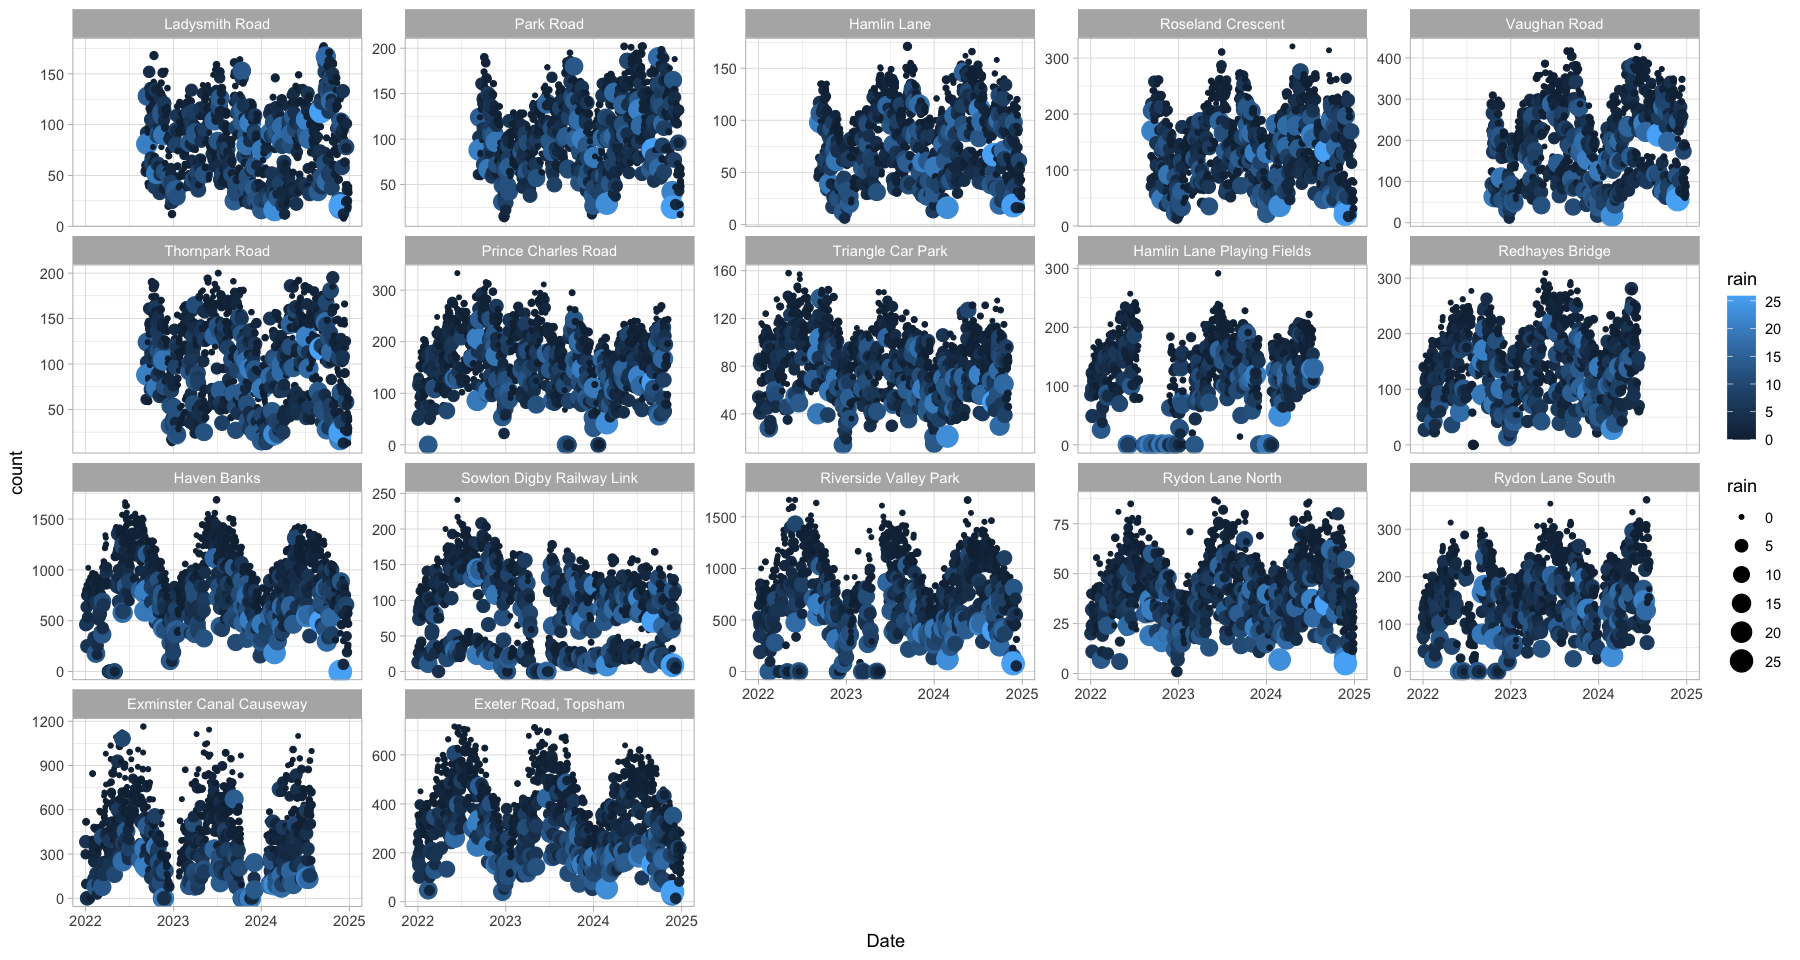

In [92]:
ggplot(data = df %>% filter(mode=='Cyclist'), aes(x=Date, y=count, size=rain, color=rain)) + 
    geom_point() + 
    facet_wrap(~location, scales = "free_y") +
    theme_light()

In [140]:
df %>% filter(rain == 0 & school.hol == 0 & mode == 'Cyclist')

Date       weekday doy ast.3bool ast.2bool location       school.hol year
1   2022-09-17 6       260 Before    No        Ladysmith Road 0          0   
2   2022-12-15 4       349 Before    No        Ladysmith Road 0          0   
3   2022-12-16 5       350 Before    No        Ladysmith Road 0          0   
4   2023-01-20 5        20 Before    No        Ladysmith Road 0          1   
5   2023-01-23 1        23 Before    No        Ladysmith Road 0          1   
6   2023-04-20 4       110 Before    No        Ladysmith Road 0          1   
7   2023-04-25 2       115 Before    No        Ladysmith Road 0          1   
8   2023-05-21 7       141 Before    No        Ladysmith Road 0          1   
9   2023-05-22 1       142 Before    No        Ladysmith Road 0          1   
10  2023-05-26 5       146 Before    No        Ladysmith Road 0          1   
11  2023-05-27 6       147 Before    No        Ladysmith Road 0          1   
12  2023-06-04 7       155 Before    No        Ladysmith Road 0          1   
13  2023-06-06 2       157 Before    No        Ladysmith Road 0          1   
14  2023-06-14 3       165 Before    No        Ladysmith Road 0          1   
15  2023-06-15 4       166 Before    No        Ladysmith Road 0          1   
16  2023-09-04 1       247 During    Yes       Ladysmith Road 0          1   
17  2023-09-06 3       249 During    Yes       Ladysmith Road 0          1   
18  2023-10-09 1       282 During    Yes       Ladysmith Road 0          1   
19  2023-10-15 7       288 During    Yes       Ladysmith Road 0          1   
20  2024-01-18 4        18 During    Yes       Ladysmith Road 0          2   
21  2024-01-19 5        19 During    Yes       Ladysmith Road 0          2   
22  2024-09-14 6       258 After     No        Ladysmith Road 0          2   
23  2024-09-17 2       261 After     No        Ladysmith Road 0          2   
24  2022-09-17 6       260 Before    No        Park Road      0          0   
25  2022-12-15 4       349 Before    No        Park Road      0          0   
26  2022-12-16 5       350 Before    No        Park Road      0          0   
27  2023-01-20 5        20 Before    No        Park Road      0          1   
28  2023-01-23 1        23 Before    No        Park Road      0          1   
29  2023-04-20 4       110 Before    No        Park Road      0          1   
30  2023-04-25 2       115 Before    No        Park Road      0          1   
⋮   ⋮          ⋮       ⋮   ⋮         ⋮         ⋮              ⋮          ⋮   
104 2023-09-04 1       247 During    Yes       Vaughan Road   0          1   
105 2023-09-06 3       249 During    Yes       Vaughan Road   0          1   
106 2023-10-09 1       282 During    Yes       Vaughan Road   0          1   
107 2023-10-15 7       288 During    Yes       Vaughan Road   0          1   
108 2024-01-18 4        18 During    Yes       Vaughan Road   0          2   
109 2024-01-19 5        19 During    Yes       Vaughan Road   0          2   
110 2024-09-14 6       258 After     No        Vaughan Road   0          2   
111 2024-09-17 2       261 After     No        Vaughan Road   0          2   
112 2022-12-15 4       349 Before    No        Thornpark Road 0          0   
113 2022-12-16 5       350 Before    No        Thornpark Road 0          0   
114 2023-01-20 5        20 Before    No        Thornpark Road 0          1   
115 2023-01-23 1        23 Before    No        Thornpark Road 0          1   
116 2023-04-20 4       110 Before    No        Thornpark Road 0          1   
117 2023-04-25 2       115 Before    No        Thornpark Road 0          1   
118 2023-05-21 7       141 Before    No        Thornpark Road 0          1   
119 2023-05-22 1       142 Before    No        Thornpark Road 0          1   
120 2023-05-26 5       146 Before    No        Thornpark Road 0          1   
121 2023-05-27 6       147 Before    No        Thornpark Road 0          1   
122 2023-06-04 7       155 Before    No        Thornpark Road 0          1   
123 2023-06-06 2       157

## Model Fitting

In [ ]:
nb.m3 <- gam(count ~ s(location, bs="re") + 
                s(weekday, location, bs='fs', xt=list(bs="tp"), k=7) + 
                s(ast.3bool, by=location, bs='re') + 
                s(school.hol, bs='re') +
                s(bst.bool, bs='re') +
                s(bankhol.bool, bs='re') +
                s(doy, bs = 'cc', k=14) +
                s(rain, bs='tp', k=12),
            data = df2,
            family = nb, method='REML')

Warning message in gam.side(sm, X, tol = .Machine$double.eps^0.5):
“model has repeated 1-d smooths of same variable.”


In [93]:
nb.m5 <- gam(count ~ s(location, bs="re") + 
                s(weekday, by=location, bs='tp', k=7) + 
                s(ast.3bool, by=location, bs='re') + 
                s(school.hol, by=location, bs='re') +
                s(bankhol.bool, bs='re') +
                te(rain, doy, bs=c('tp', 'cc'), k=c(4, 14)),
            data = df,
            family = nb, method='REML')


In [98]:
qs

ERROR: Error: object 'qs' not found


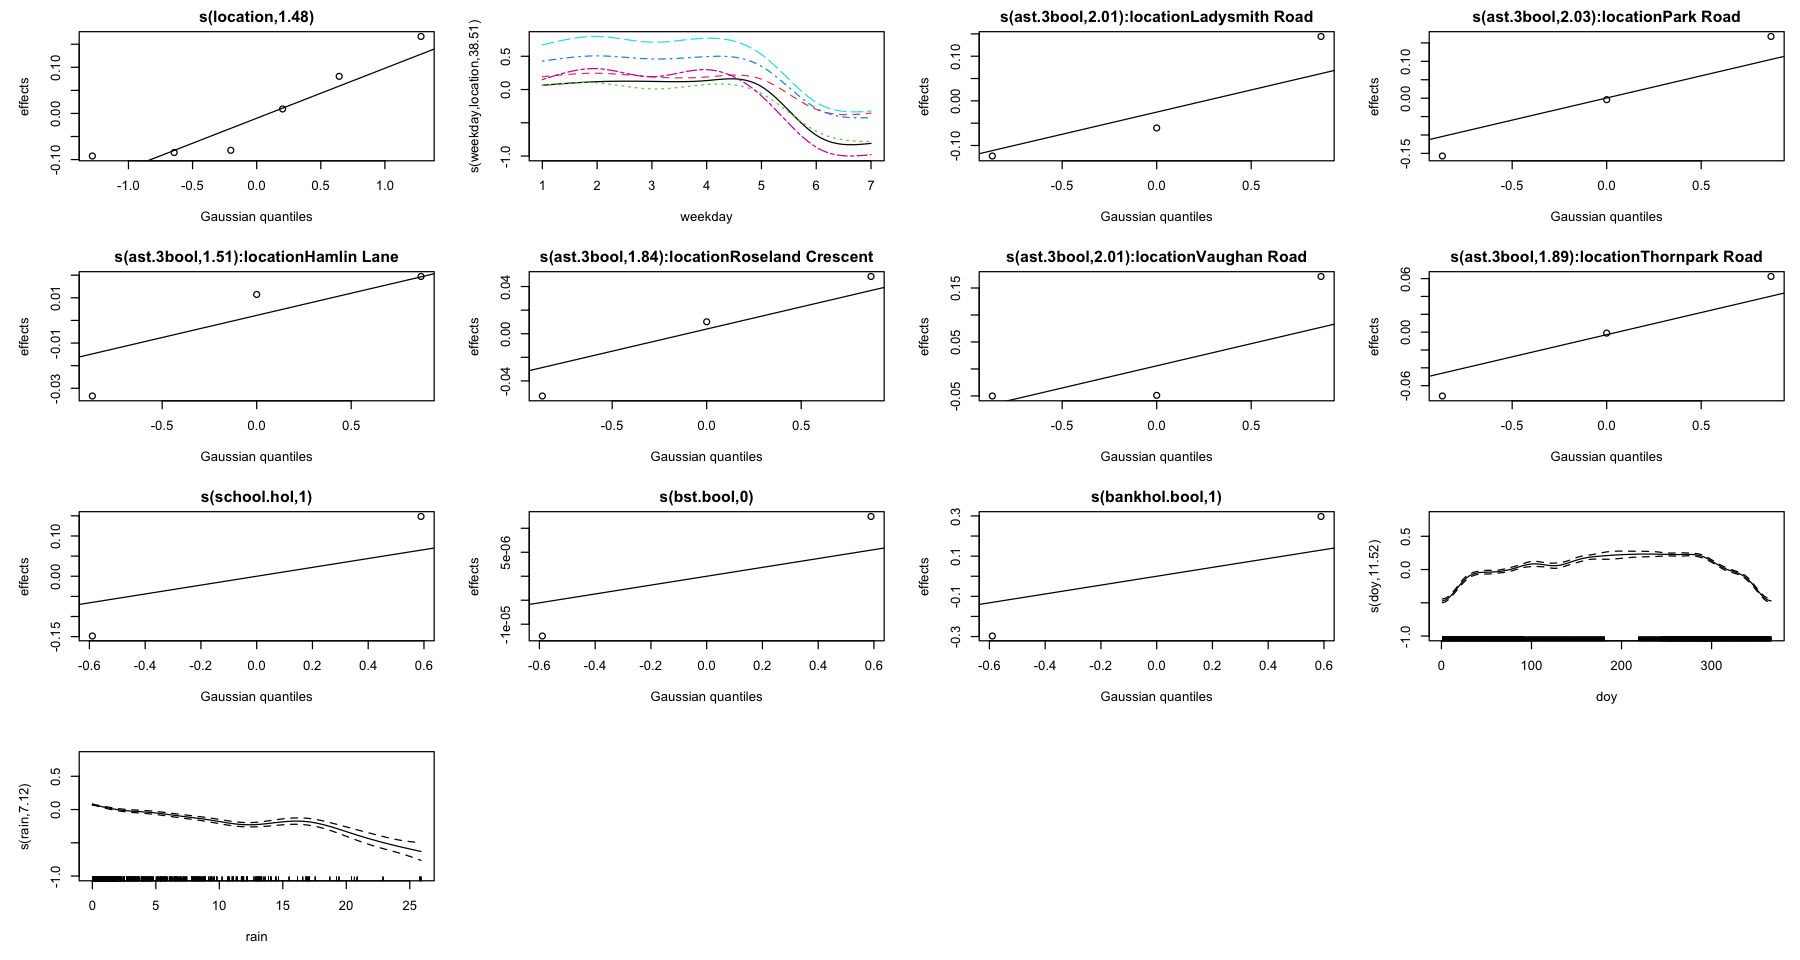

In [152]:
par(bg = "white")
plot(nb.m3, pages=1)


In [336]:
summary(nb.m1)


Family: Negative Binomial(20.337) 
Link function: log 

Formula:
count ~ s(location, bs = "re") + s(weekday, location, bs = "fs", 
    xt = list(bs = "tp"), k = 7) + s(ast.3bool, bs = "re") + 
    s(school.hol, bs = "re") + s(doy, bs = "cc", k = 14) + s(rain, 
    bs = "ts", k = 5)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   4.4098     0.2452   17.99   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df    Chi.sq  p-value    
s(location)          0.7583      5 8.840e-01  < 2e-16 ***
s(weekday,location) 39.2448     41 8.044e+05 1.92e-05 ***
s(ast.3bool)         1.9843      2 2.027e+02  < 2e-16 ***
s(school.hol)        0.9986      1 7.227e+02  < 2e-16 ***
s(doy)              11.5072     12 3.523e+03  < 2e-16 ***
s(rain)              2.6913      4 5.359e+02  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [94]:
summary(nb.m5)


Family: Negative Binomial(2.909) 
Link function: log 

Formula:
count ~ s(location, bs = "re") + s(weekday, by = location, bs = "tp", 
    k = 7) + s(ast.3bool, by = location, bs = "re") + s(school.hol, 
    by = location, bs = "re") + s(bankhol.bool, bs = "re") + 
    te(rain, doy, bs = c("tp", "cc"), k = c(4, 14))

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   4.8001     0.2719   17.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                                       edf Ref.df    Chi.sq
s(location)                                      15.651523 16.000 9.779e+05
s(weekday):locationLadysmith Road                 5.357145  5.842 2.870e+02
s(weekday):locationPark Road                      4.327724  5.102 1.268e+02
s(weekday):locationHamlin Lane                    5.008329  5.646 2.640e+02
s(weekday):locationRoseland Crescent              5.122989 

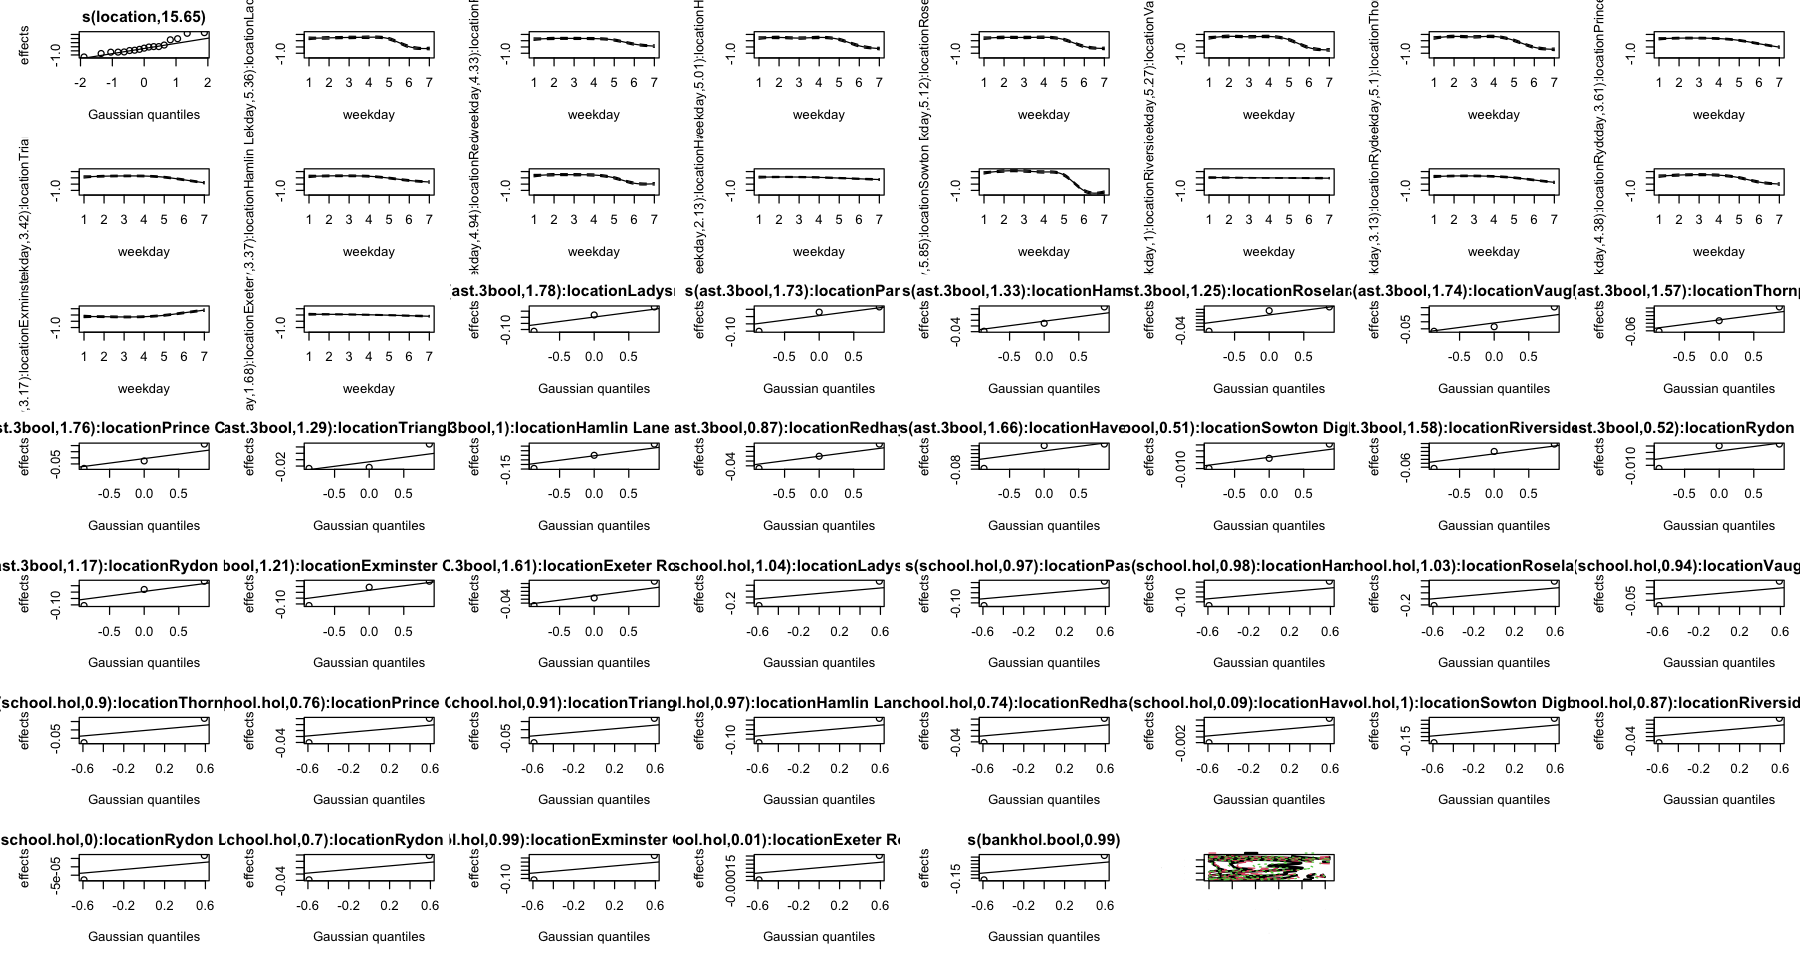

In [95]:
par(bg = "white")
plot(nb.m5, pages=1)



Method: REML   Optimizer: outer newton
full convergence after 15 iterations.
Gradient range [-0.004265356,0.003690653]
(score 94345.25 & scale 1).
Hessian positive definite, eigenvalue range [0.001275075,6472.172].
Model rank =  258 / 258 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                                       k'      edf k-index
s(location)                                      17.00000 15.65152      NA
s(weekday):locationLadysmith Road                 6.00000  5.35715    0.92
s(weekday):locationPark Road                      6.00000  4.32772    0.92
s(weekday):locationHamlin Lane                    6.00000  5.00833    0.92
s(weekday):locationRoseland Crescent              6.00000  5.12299    0.92
s(weekday):locationVaughan Road                   6.00000  5.26710    0.92
s(weekday):locationThornpark Road                 6.00000  5.10444    0.92
s(weekday):locationPrince Cha

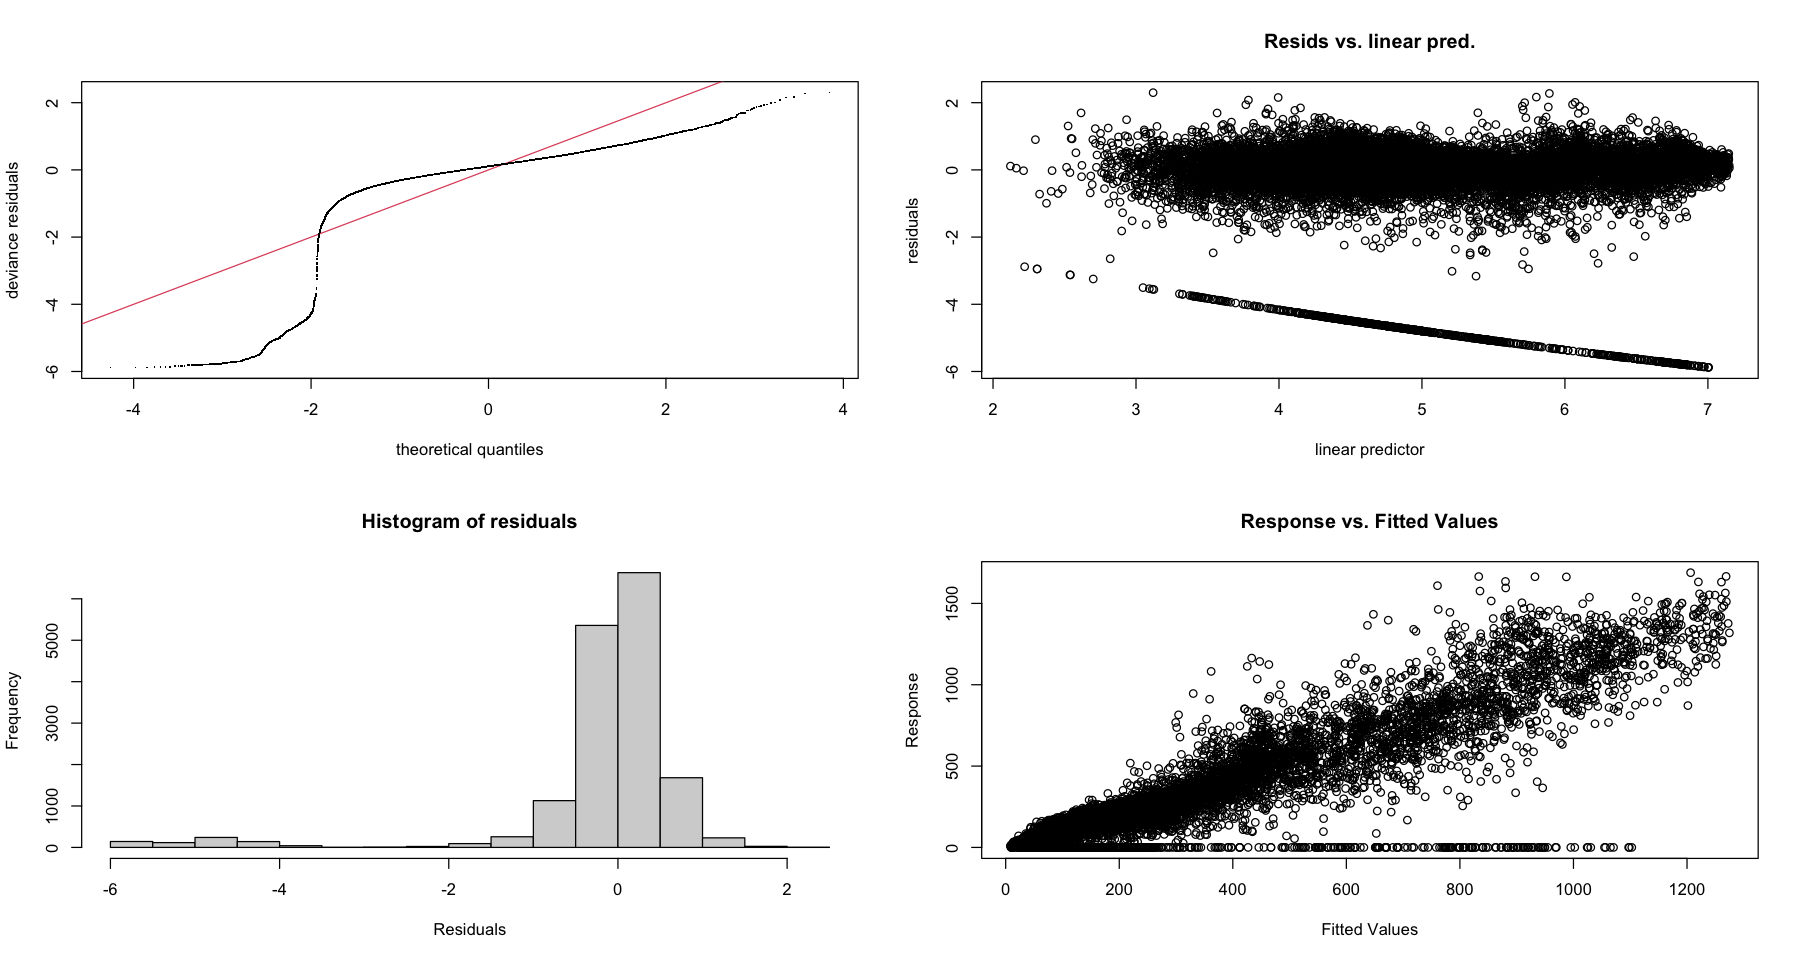

In [96]:
par(bg = "white")
gam.check(nb.m5)

## Define conditional prediction grid

In [182]:
pred.avg.weekday = datagrid(model = nb.m5, ast.3bool = 'Before', weekday=seq(1,5), location=names(sheets), rain=0, doy=seq(1,365))

## Year Effect

In [177]:
avg_predictions(nb.m5, variables = 'year', type = 'response', conf_level=0.9, vcov=TRUE)

year estimate std.error statistic p.value s.value conf.low conf.high
1 0    106.3956 2.0847713  51.03467 0       Inf     102.9665 109.8248 
2 1    116.7540 0.7148277 163.33166 0       Inf     115.5782 117.9298 
3 2    128.9940 1.3830346  93.26879 0       Inf     126.7191 131.2688

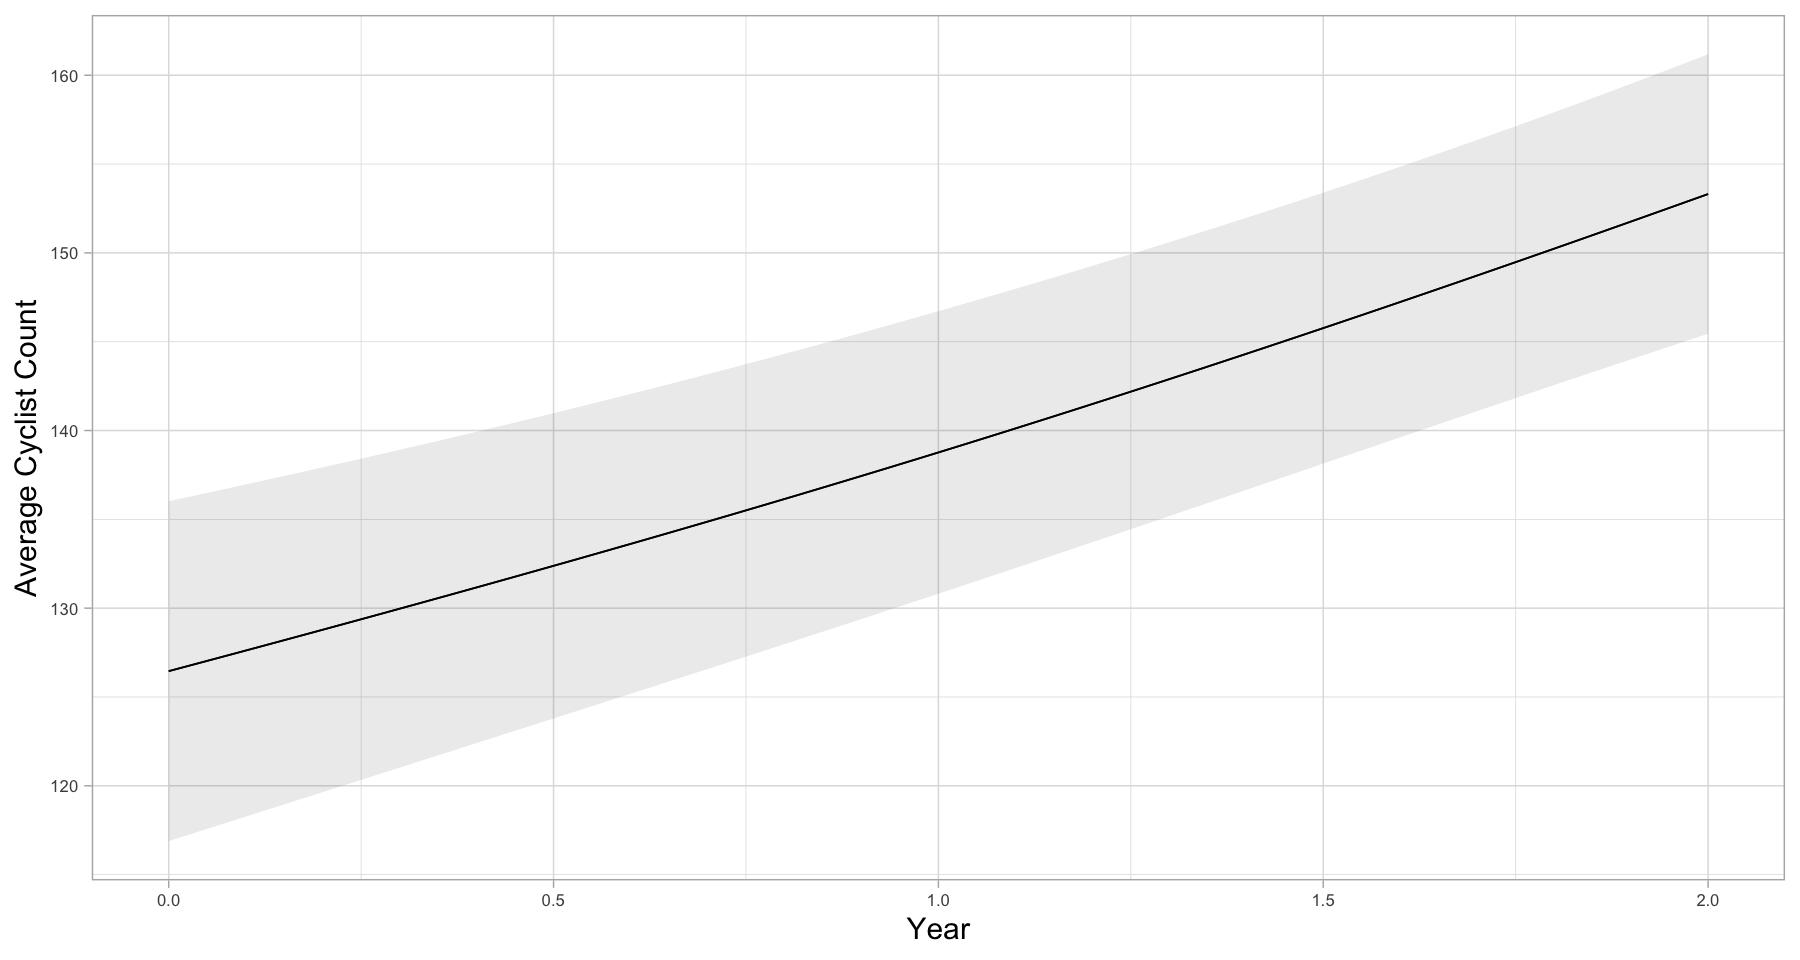

In [179]:
# Conditional (partial) effect
plot_predictions(nb.m5, condition = 'year', type = 'response', vcov = TRUE,
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), weekday=c(1,2,3,4,5))) + 
labs(x = "Year", y = "Average Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## Location Effect

In [180]:
# Marginal effect of location
avg_predictions(nb.m5, variables = 'location', type = 'response', conf_level=0.9, vcov=TRUE)


location          estimate  std.error statistic p.value s.value conf.low 
1 Ladysmith Road     84.30293 0.6291698 133.9907  0       Inf      83.26804
2 Park Road         113.61210 0.8011447 141.8122  0       Inf     112.29434
3 Hamlin Lane        83.44313 0.6179799 135.0256  0       Inf      82.42664
4 Roseland Crescent 144.21962 1.0144103 142.1709  0       Inf     142.55106
5 Vaughan Road      199.73876 1.4068408 141.9768  0       Inf     197.42471
6 Thornpark Road    101.14781 0.7383994 136.9825  0       Inf      99.93325
  conf.high
1  85.33782
2 114.92987
3  84.45961
4 145.88817
5 202.05281
6 102.36237

In [184]:
# Conditional estimate for average weekday
avg_predictions(nb.m5, by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
newdata = pred.avg.weekday)

location          estimate std.error statistic p.value s.value conf.low
1 Ladysmith Road    132.1515 2.210140  59.79326  0       Inf     128.5161
2 Park Road         143.1358 2.243093  63.81182  0       Inf     139.4463
3 Hamlin Lane       115.0654 1.928506  59.66557  0       Inf     111.8933
4 Roseland Crescent 204.2279 3.289693  62.08114  0       Inf     198.8168
5 Vaughan Road      279.2028 4.325676  64.54547  0       Inf     272.0877
6 Thornpark Road    158.8064 2.621308  60.58289  0       Inf     154.4948
  conf.high
1 135.7868 
2 146.8254 
3 118.2375 
4 209.6389 
5 286.3179 
6 163.1181

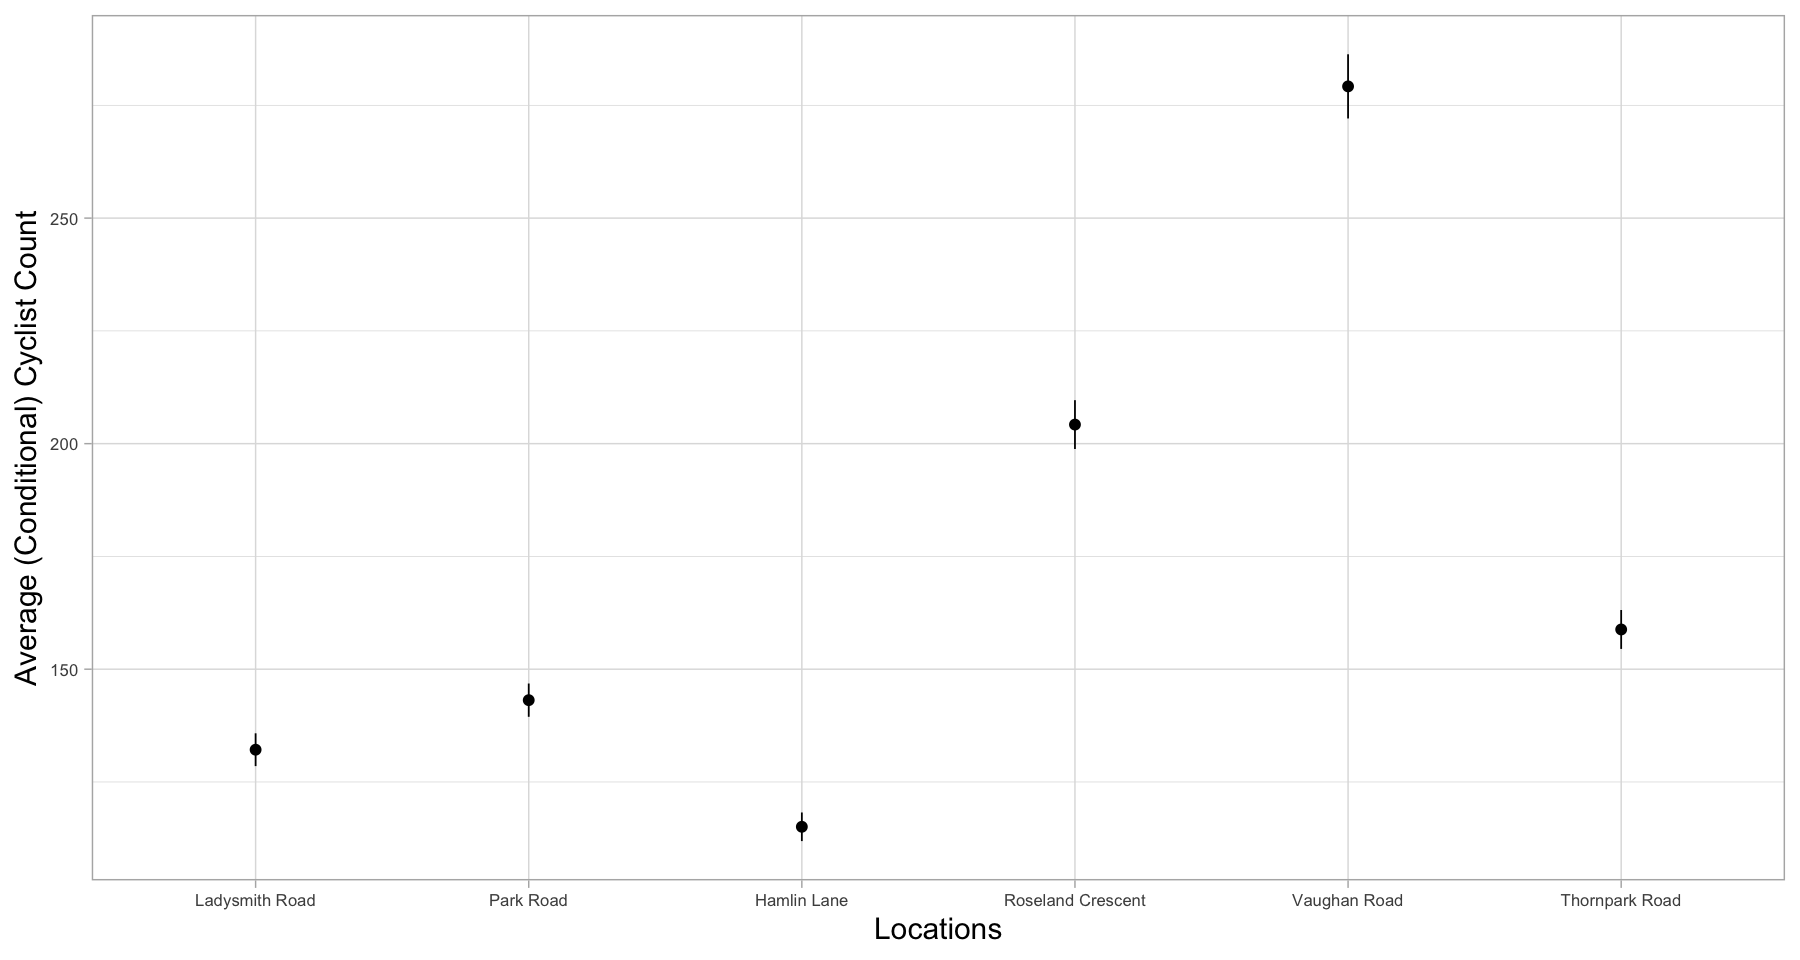

In [185]:
p1 <- plot_predictions(nb.m5, by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, newdata = pred.avg.weekday)
p1 + labs(x = "Locations", y = "Average (Conditional) Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## School Holiday Effect

In [196]:
avg_comparisons(nb.m5, variables='school.hol', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'ratio')

term       contrast          location          estimate std.error  statistic
1 school.hol mean(0) / mean(1) Ladysmith Road    1.491854 0.03003663 49.66782 
2 school.hol mean(0) / mean(1) Park Road         1.246043 0.02358925 52.82249 
3 school.hol mean(0) / mean(1) Hamlin Lane       1.262720 0.02498290 50.54339 
4 school.hol mean(0) / mean(1) Roseland Crescent 1.468589 0.02762162 53.16808 
5 school.hol mean(0) / mean(1) Vaughan Road      1.188229 0.02146371 55.35990 
6 school.hol mean(0) / mean(1) Thornpark Road    1.138162 0.02170371 52.44090 
  p.value s.value conf.low conf.high predicted_lo predicted_hi predicted
1 0       Inf     1.442448 1.541260   81.81901    122.0620     122.0620 
2 0       Inf     1.207242 1.284844  106.23416    132.3723     132.3723 
3 0       Inf     1.221627 1.303814   80.85397    102.0960     102.0960 
4 0       Inf     1.423155 1.514022  120.87392    177.5141     177.5141 
5 0       Inf     1.152924 1.223533  268.26148    318.7560     318.7560 
6 0       Inf     1.102463 1.173862  107.45451    122.3007     122.3007

Condition estimate for average weekday:

In [197]:
avg_comparisons(nb.m5, variables='school.hol', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'ratio',
newdata = pred.avg.weekday)

term       contrast          location          estimate std.error  statistic
1 school.hol mean(0) / mean(1) Ladysmith Road    1.491854 0.03003662 49.66783 
2 school.hol mean(0) / mean(1) Park Road         1.246043 0.02358926 52.82248 
3 school.hol mean(0) / mean(1) Hamlin Lane       1.262720 0.02498290 50.54339 
4 school.hol mean(0) / mean(1) Roseland Crescent 1.468589 0.02762161 53.16810 
5 school.hol mean(0) / mean(1) Vaughan Road      1.188229 0.02146370 55.35992 
6 school.hol mean(0) / mean(1) Thornpark Road    1.138162 0.02170370 52.44092 
  p.value s.value conf.low conf.high predicted_lo predicted_hi predicted
1 0       Inf     1.442448 1.541260   49.91784     74.47012     74.47012
2 0       Inf     1.207242 1.284844   65.12968     81.15439     81.15439
3 0       Inf     1.221627 1.303814   52.82315     66.70087     66.70087
4 0       Inf     1.423155 1.514022   79.51687    116.77757    116.77757
5 0       Inf     1.152924 1.223533  131.45947    156.20392    156.20392
6 0       Inf     1.102463 1.173862   78.17698     88.97809     88.97809

In [198]:
avg_comparisons(nb.m5, variables='school.hol', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'difference',
newdata = pred.avg.weekday)

term       contrast location          estimate std.error statistic
1 school.hol 0 - 1    Ladysmith Road    43.56942 2.029526  21.467776
2 school.hol 0 - 1    Park Road         28.26353 2.296527  12.307074
3 school.hol 0 - 1    Hamlin Lane       23.94039 1.907287  12.552061
4 school.hol 0 - 1    Roseland Crescent 65.16383 2.964255  21.983210
5 school.hol 0 - 1    Vaughan Road      44.22884 4.425077   9.995044
6 school.hol 0 - 1    Thornpark Road    19.27761 2.728316   7.065755
  p.value       s.value   conf.low conf.high
1 3.115764e-102 337.19708 40.23114 46.90769 
2  8.297762e-35 113.21476 24.48608 32.04098 
3  3.872940e-36 117.63598 20.80318 27.07760 
4 4.169179e-107 353.38654 60.28807 70.03960 
5  1.602163e-23  75.72433 36.95024 51.50745 
6  1.597448e-12  39.18737 14.78993 23.76529

In [200]:
p2 <- plot_comparisons(nb.m5, variables='school.hol', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, newdata = pred.avg.weekday)

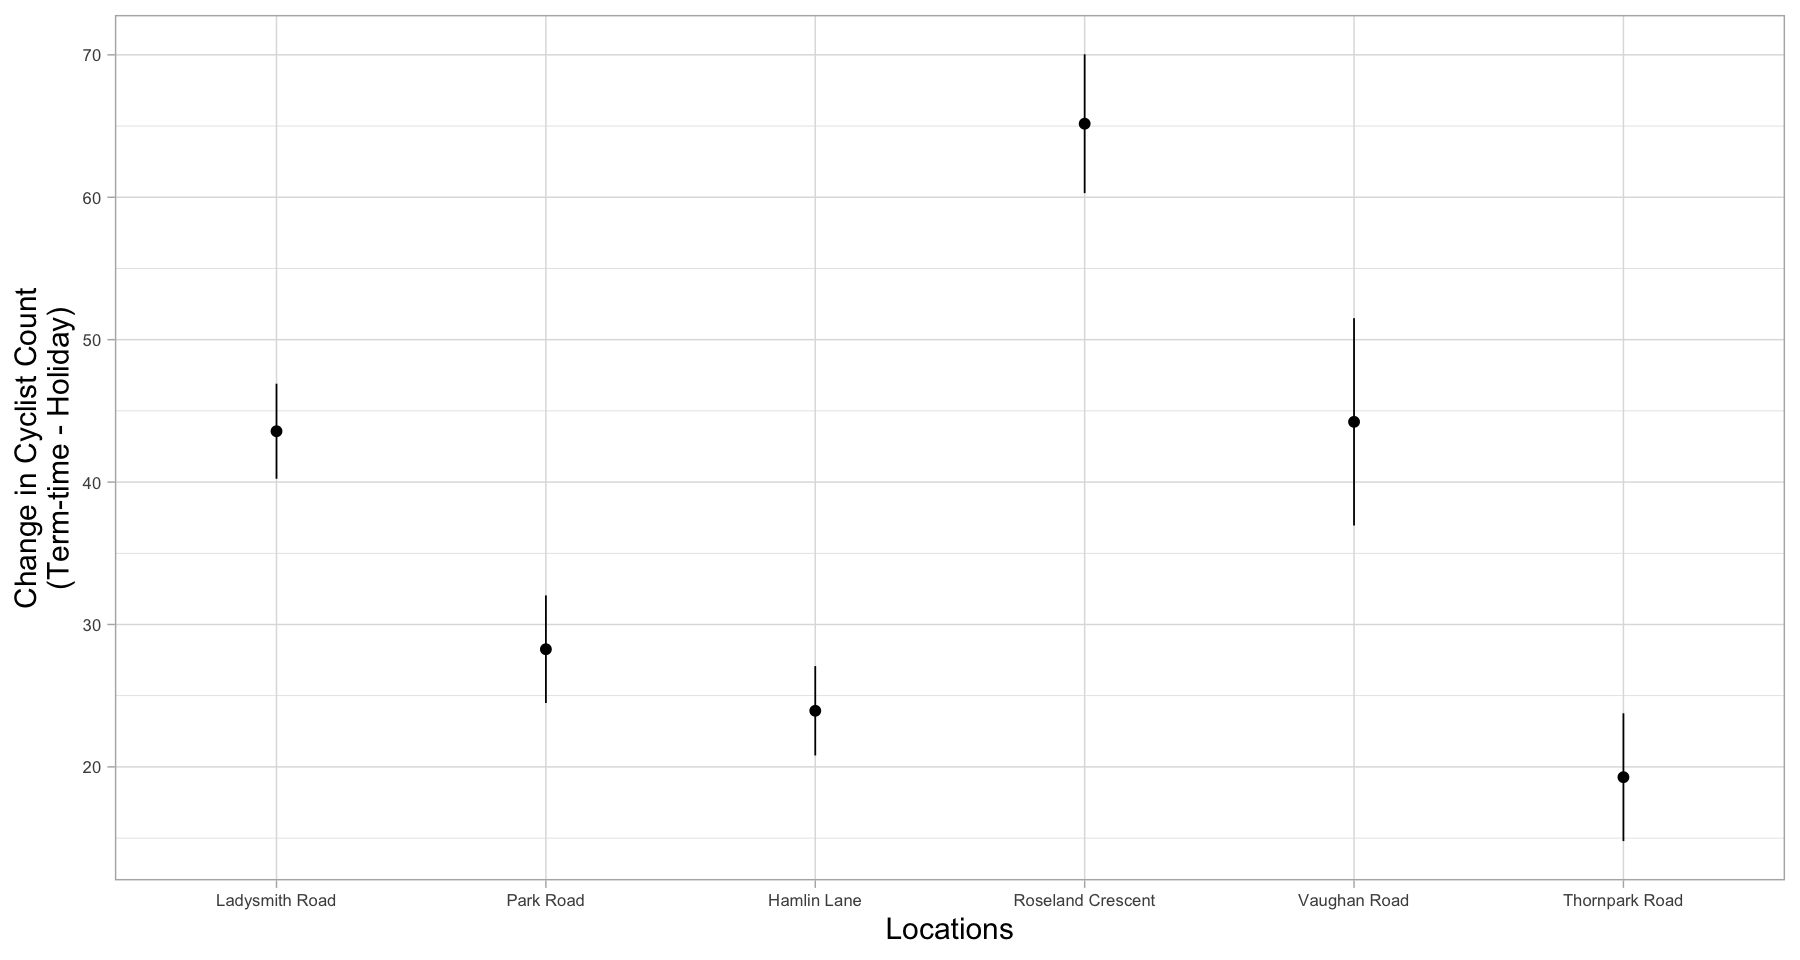

In [201]:
# Plot styling
p2 + labs(x = "Locations", y = "Change in Cyclist Count\n(Term-time - Holiday)") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## Bank Holiday Effect

In [303]:
avg_comparisons(nb.m5, variables='bankhol.bool', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
comparison = function(hi, lo) mean(lo)-mean(hi),
newdata = pred.avg.weekday)

term         contrast location          estimate   std.error statistic
1 bankhol.bool 0, 1     Ladysmith Road     -47.40428 1.763328  -26.88342
2 bankhol.bool 0, 1     Park Road          -50.02364 1.855622  -26.95788
3 bankhol.bool 0, 1     Hamlin Lane        -43.93109 1.671916  -26.27590
4 bankhol.bool 0, 1     Roseland Crescent  -78.99089 2.909555  -27.14879
5 bankhol.bool 0, 1     Vaughan Road      -106.90329 3.960896  -26.98967
6 bankhol.bool 0, 1     Thornpark Road     -52.27052 1.956297  -26.71912
  p.value       s.value  conf.low   conf.high 
1 3.432365e-159 526.4074  -50.30469  -44.50386
2 4.610933e-160 529.3034  -53.07587  -46.97142
3 3.617177e-152 503.0782  -46.68115  -41.18103
4 2.616610e-162 536.7647  -83.77668  -74.20510
5 1.953770e-160 530.5422 -113.41839 -100.38820
6 2.822486e-157 520.0457  -55.48834  -49.05270

In [297]:
avg_comparisons(nb.m5, variables='bankhol.bool', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
comparison = function(hi, lo) mean(lo)/mean(hi),
newdata = pred.avg.weekday)

term         contrast location          estimate  std.error  statistic
1 bankhol.bool 0, 1     Ladysmith Road    0.5597552 0.01489841 37.57147 
2 bankhol.bool 0, 1     Park Road         0.5597552 0.01489841 37.57148 
3 bankhol.bool 0, 1     Hamlin Lane       0.5597552 0.01489841 37.57147 
4 bankhol.bool 0, 1     Roseland Crescent 0.5597552 0.01489841 37.57147 
5 bankhol.bool 0, 1     Vaughan Road      0.5597552 0.01489841 37.57148 
6 bankhol.bool 0, 1     Thornpark Road    0.5597552 0.01489841 37.57148 
  p.value s.value conf.low  conf.high
1 0       Inf     0.5352495 0.5842609
2 0       Inf     0.5352495 0.5842609
3 0       Inf     0.5352495 0.5842609
4 0       Inf     0.5352494 0.5842609
5 0       Inf     0.5352495 0.5842609
6 0       Inf     0.5352495 0.5842608

In [203]:
p3 <- plot_comparisons(nb.m5, variables='bankhol.bool', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
comparison = function(hi, lo) mean(lo)-mean(hi),
newdata = pred.avg.weekday)

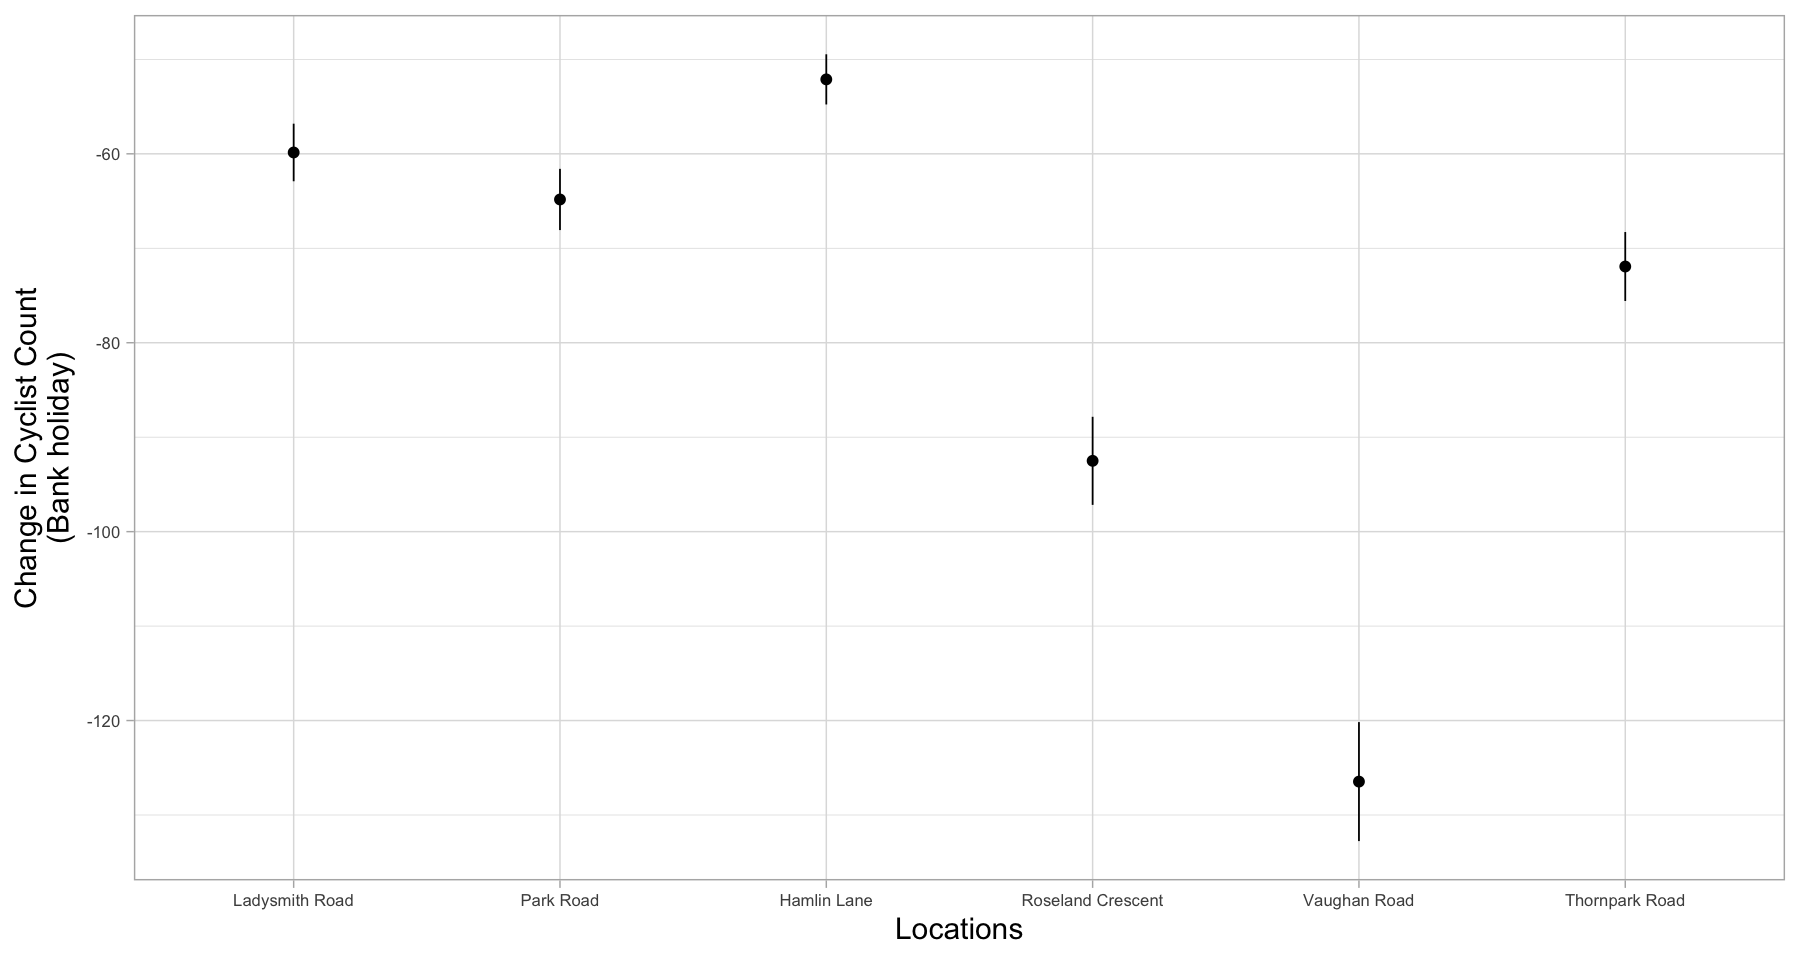

In [204]:
# Plot styling
p3 + labs(x = "Locations", y = "Change in Cyclist Count\n(Bank holiday)") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## AST Effect

In [12]:
avg_comparisons(nb.m5, variables='ast.3bool', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'ratio')

term      contrast                    estimate std.error   statistic p.value
1 ast.3bool mean(After) / mean(Before)  1.064386 0.010190839 104.4454  0      
2 ast.3bool mean(During) / mean(Before) 1.018795 0.006965342 146.2663  0      
  s.value conf.low conf.high predicted_lo predicted_hi predicted
1 Inf     1.047623 1.081148  123.0488     129.5683     123.0488 
2 Inf     1.007338 1.030252  123.0488     106.4298     123.0488

In [13]:
avg_comparisons(nb.m5, variables='ast.3bool', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'difference')

term      contrast        estimate std.error statistic p.value      s.value  
1 ast.3bool After - Before  7.606940 1.1805165 6.443739  1.165658e-10 32.998137
2 ast.3bool During - Before 2.220536 0.8146315 2.725817  6.414255e-03  7.284502
  conf.low  conf.high
1 5.6651628 9.548716 
2 0.8805868 3.560486

In [188]:
avg_comparisons(nb.m5, variables = 'ast.3bool', by='location', type = "response", conf_level=0.9, vcov=TRUE, comparison = 'ratio') %>% 
inferences(method = "simulation")

term      contrast                    location          estimate 
1  ast.3bool mean(After) / mean(Before)  Ladysmith Road    0.8778633
2  ast.3bool mean(After) / mean(Before)  Park Road         0.9807731
3  ast.3bool mean(After) / mean(Before)  Hamlin Lane       0.8271331
4  ast.3bool mean(After) / mean(Before)  Roseland Crescent 0.8754772
5  ast.3bool mean(After) / mean(Before)  Vaughan Road      0.9730578
6  ast.3bool mean(After) / mean(Before)  Thornpark Road    0.7378777
7  ast.3bool mean(During) / mean(Before) Ladysmith Road    0.7873653
8  ast.3bool mean(During) / mean(Before) Park Road         1.0439741
9  ast.3bool mean(During) / mean(Before) Hamlin Lane       1.0069627
10 ast.3bool mean(During) / mean(Before) Roseland Crescent 0.9913631
11 ast.3bool mean(During) / mean(Before) Vaughan Road      0.9410309
12 ast.3bool mean(During) / mean(Before) Thornpark Road    0.7822601
   predicted_lo predicted_hi predicted conf.low  conf.high
1  122.0620     107.15375    122.0620  0.8358787 0.9315188
2  132.3723     129.82724    132.3723  0.9306883 1.0246603
3  102.0960      84.44695    102.0960  0.7841041 0.8706334
4  177.5141     155.40952    177.5141  0.8328144 0.9265517
5  318.7560     310.16801    318.7560  0.9304869 1.0185252
6  122.3007      90.24292    122.3007  0.7007332 0.7776071
7  122.0620      96.10739    122.0620  0.7591338 0.8115637
8  132.3723     138.19330    132.3723  1.0117466 1.0792516
9  102.0960     102.80681    102.0960  0.9740398 1.0440813
10 177.5141     175.98089    177.5141  0.9579874 1.0223269
11 318.7560     299.95924    318.7560  0.9115907 0.9707512
12 122.3007      95.67093    122.3007  0.7573172 0.8108785

In [189]:
pc1 <- plot_comparisons(nb.m5, variables = 'ast.3bool', by="location", type='response', conf_level=0.9, vcov=TRUE, comparison = 'difference')

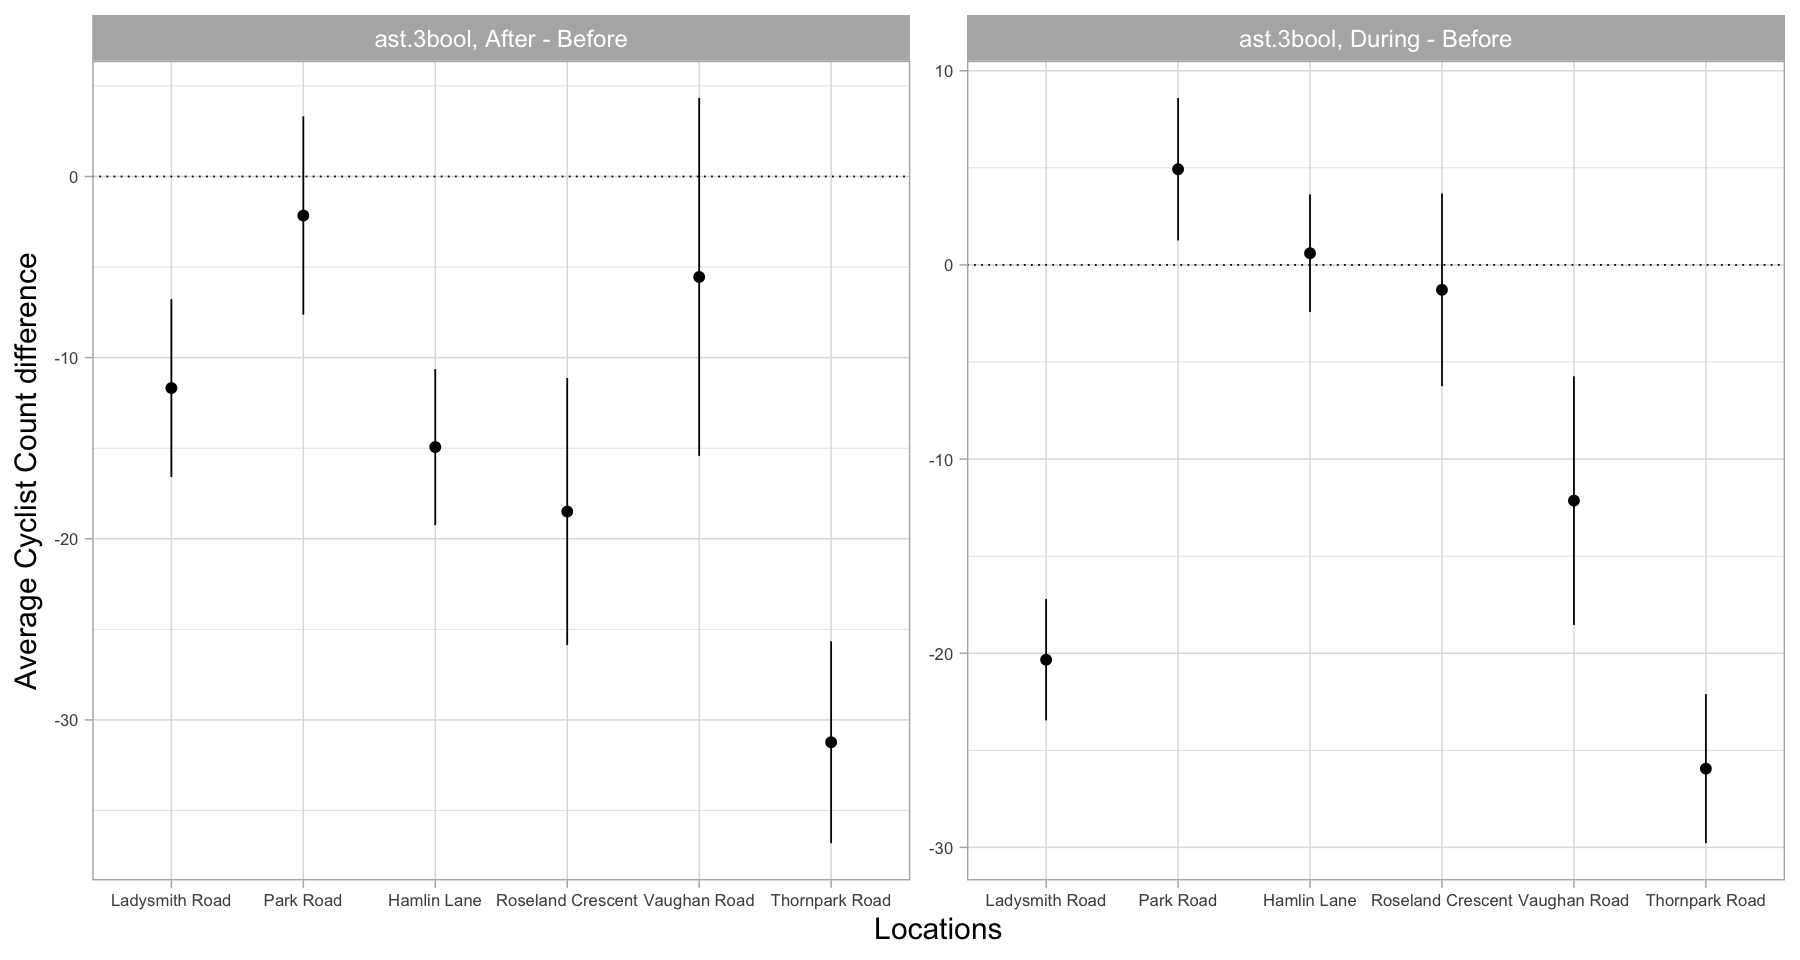

In [191]:
pc1 +
geom_hline(yintercept=0, linetype="dotted") + 
labs(x = "Locations", y = "Average Cyclist Count difference") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## Rain Effect

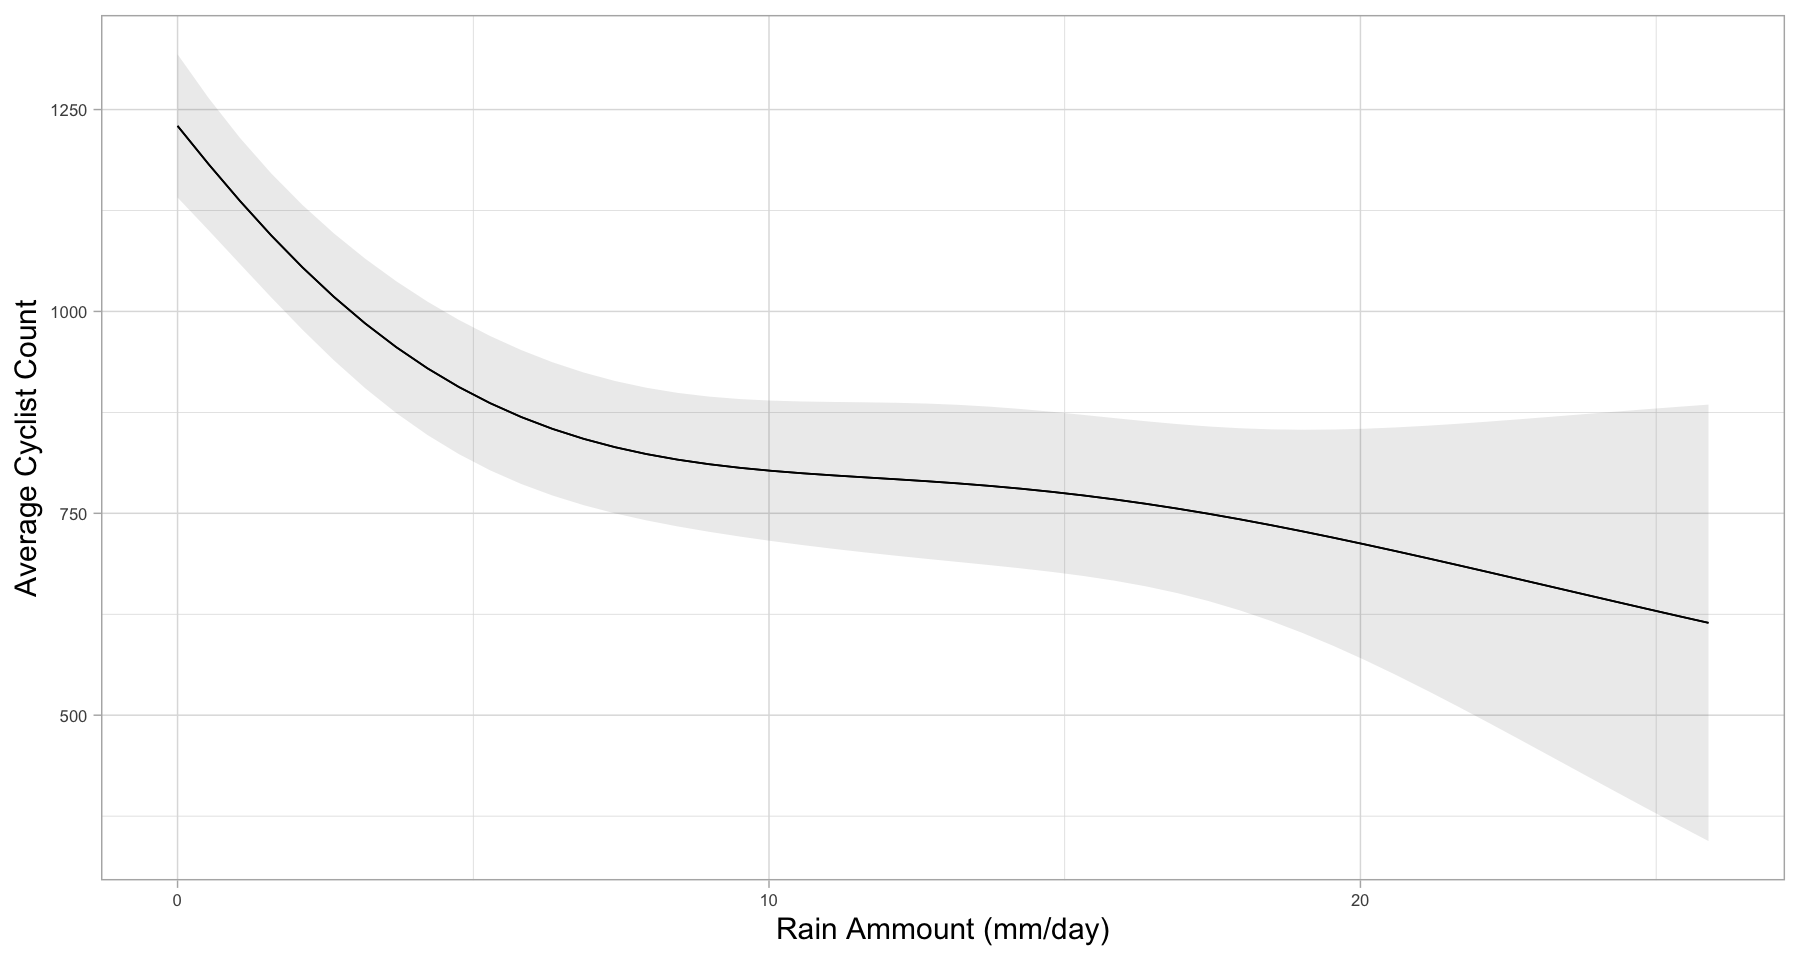

In [97]:
# Conditional (partial) effect
plot_predictions(nb.m5, condition = 'rain', type = 'response', vcov = TRUE,
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), weekday=c(1,2,3,4,5))) + 
labs(x = "Rain Ammount (mm/day)", y = "Average Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

In [198]:
predictions(nb.m5, variables = list(rain=c(0, 26)), type = 'response', vcov = TRUE, newdata = 'mean')

rowid rowidcf estimate  std.error statistic p.value       s.value   
1 1     1       130.65937  5.225441 25.004470 5.465997e-138 455.975593
2 2     1        81.77909 27.866275  2.934697  3.338730e-03   8.226485
  conf.low  conf.high location       weekday  ast.3bool school.hol bankhol.bool
1 120.41769 140.901   Ladysmith Road 3.996264 Before    0          0           
2  27.16219 136.396   Ladysmith Road 3.996264 Before    0          0           
  doy      count rain
1 203.4996 46     0  
2 203.4996 46    26

## Day of Week

In [222]:
plot_predictions(nb.m5, condition = list(weekday=seq(1,7)), type = 'response', vcov = TRUE,
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), rain=0), draw=FALSE)

rowid estimate  std.error statistic p.value      s.value  conf.low  conf.high
1 1     111.27922 5.843152  19.04438  7.314511e-81 266.2054  99.82685 122.73158
2 2     116.94578 6.143541  19.03557  8.655101e-81 265.9626 104.90466 128.98690
3 3     117.53587 6.147559  19.11911  1.750649e-81 268.2683 105.48688 129.58487
4 4     117.93812 6.199191  19.02476  1.063749e-80 265.6651 105.78793 130.08831
5 5     108.59300 5.649069  19.22317  2.368493e-82 271.1541  97.52103 119.66497
6 6      51.31041 2.754472  18.62804  1.903670e-77 254.8597  45.91175  56.70908
7 7      45.41769 2.449433  18.54212  9.441693e-77 252.5494  40.61689  50.21849
  location       ast.3bool school.hol bankhol.bool rain     doy      weekday
1 Ladysmith Road Before    0          0            2.908357 203.4996 1      
2 Ladysmith Road Before    0          0            2.908357 203.4996 2      
3 Ladysmith Road Before    0          0            2.908357 203.4996 3      
4 Ladysmith Road Before    0          0            2.908357 203.4996 4      
5 Ladysmith Road Before    0          0            2.908357 203.4996 5      
6 Ladysmith Road Before    0          0            2.908357 203.4996 6      
7 Ladysmith Road Before    0          0            2.908357 203.4996 7      
  count
1 46   
2 46   
3 46   
4 46   
5 46   
6 46   
7 46

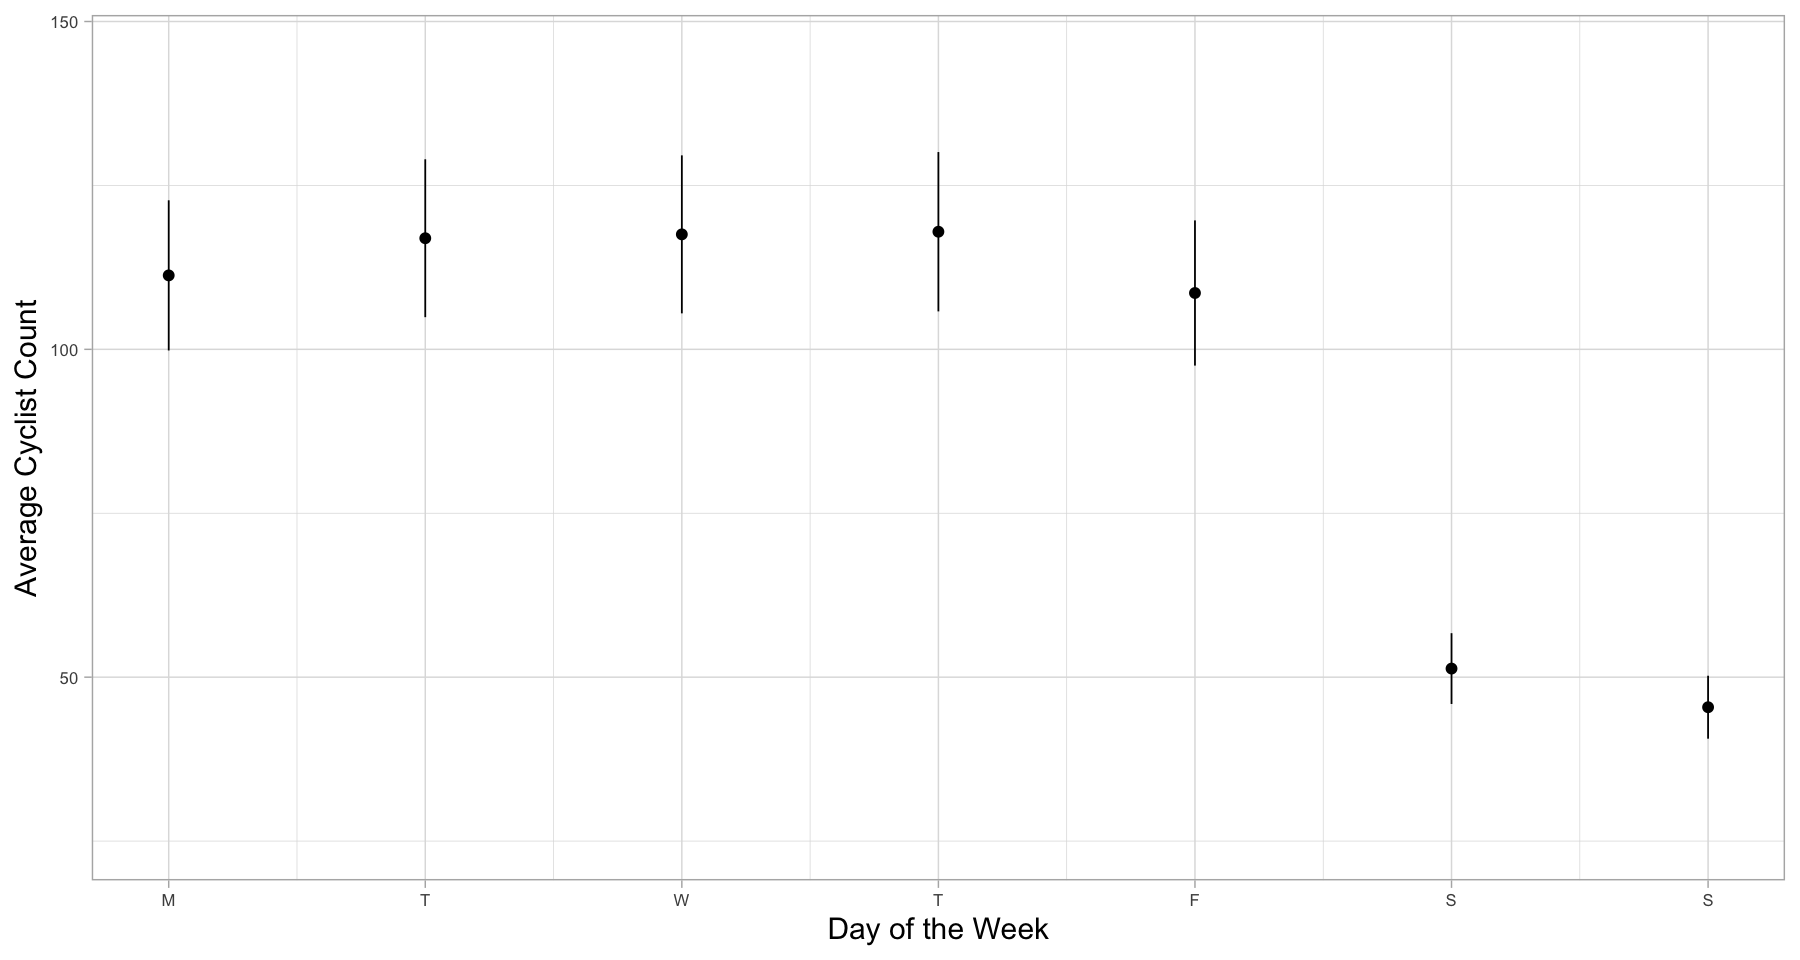

In [225]:
# Conditional (partial) effect
plot_predictions(nb.m5, condition = list(weekday=seq(1,7)), type = 'response', vcov = TRUE,
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), rain=0), draw=FALSE) |> 
ggplot() + geom_pointrange(aes(x=weekday, y=estimate, ymin=conf.low, ymax=conf.high)) + 
scale_y_continuous(limits = c(25, 145)) +
labs(x = "Day of the Week", y = "Average Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10)) +
scale_x_continuous(breaks=seq(1,7),
        labels=c("M", "T", "W", "T", "F", "S", "S"))


## Day of Year effect

In [255]:
breaks = c(as.Date("2020-01-01"), 
        as.Date("2020-02-01"), 
        as.Date("2020-03-01"), 
        as.Date("2020-04-01"),
        as.Date("2020-05-01"),
        as.Date("2020-06-01"),
        as.Date("2020-07-01"),
        as.Date("2020-08-01"),
        as.Date("2020-09-01"),
        as.Date("2020-10-01"),
        as.Date("2020-11-01"),
        as.Date("2020-12-01"))

In [284]:
pred.doy <- plot_predictions(nb.m5, condition = list(doy=seq(1,365), 'location'), type = 'response', vcov = TRUE, draw=FALSE,
newdata = 'mean')

In [288]:
pred.doy %>% group_by(location) %>% filter(estimate == min(estimate))

rowid estimate  std.error statistic p.value       s.value  conf.low 
1 2185   54.86897 1.814926  30.23208  8.976676e-201 664.5414  51.31178
2 2186   55.86316 1.818108  30.72599  2.559963e-207 686.2830  52.29973
3 2187   51.13672 1.801110  28.39178  2.554677e-177 586.6281  47.60661
4 2188   92.55997 2.955940  31.31322  3.083873e-215 712.5898  86.76644
5 2189  128.92747 4.141264  31.13240  8.779834e-213 704.4365 120.81074
6 2190   65.91432 2.190094  30.09657  5.373567e-199 658.6378  61.62181
  conf.high weekday  ast.3bool school.hol bankhol.bool rain     doy
1  58.42615 3.996264 Before    0          0            2.908357 365
2  59.42658 3.996264 Before    0          0            2.908357 365
3  54.66683 3.996264 Before    0          0            2.908357 365
4  98.35351 3.996264 Before    0          0            2.908357 365
5 137.04420 3.996264 Before    0          0            2.908357 365
6  70.20682 3.996264 Before    0          0            2.908357 365
  location          count
1 Ladysmith Road    46   
2 Park Road         46   
3 Hamlin Lane       46   
4 Roseland Crescent 46   
5 Vaughan Road      46   
6 Thornpark Road    46

In [289]:
pred.doy %>% group_by(location) %>% filter(estimate == max(estimate))

rowid estimate std.error statistic p.value       s.value  conf.low conf.high
1 1627  123.4568 3.632174  33.98978  3.154214e-253 838.7905 116.3379 130.5757 
2 1628  125.6937 3.623833  34.68530  1.312535e-263 873.2747 118.5912 132.7963 
3 1629  115.0591 3.714018  30.97969  1.012208e-210 697.5874 107.7798 122.3385 
4 1630  208.2627 5.860438  35.53705  1.317062e-276 916.4548 196.7764 219.7489 
5 1631  290.0906 8.422781  34.44119  6.101159e-260 861.0922 273.5822 306.5989 
6 1632  148.3091 4.480677  33.09972  2.999485e-240 795.6780 139.5272 157.0911 
  weekday  ast.3bool school.hol bankhol.bool rain     doy location         
1 3.996264 Before    0          0            2.908357 272 Ladysmith Road   
2 3.996264 Before    0          0            2.908357 272 Park Road        
3 3.996264 Before    0          0            2.908357 272 Hamlin Lane      
4 3.996264 Before    0          0            2.908357 272 Roseland Crescent
5 3.996264 Before    0          0            2.908357 272 Vaughan Road     
6 3.996264 Before    0          0            2.908357 272 Thornpark Road   
  count
1 46   
2 46   
3 46   
4 46   
5 46   
6 46

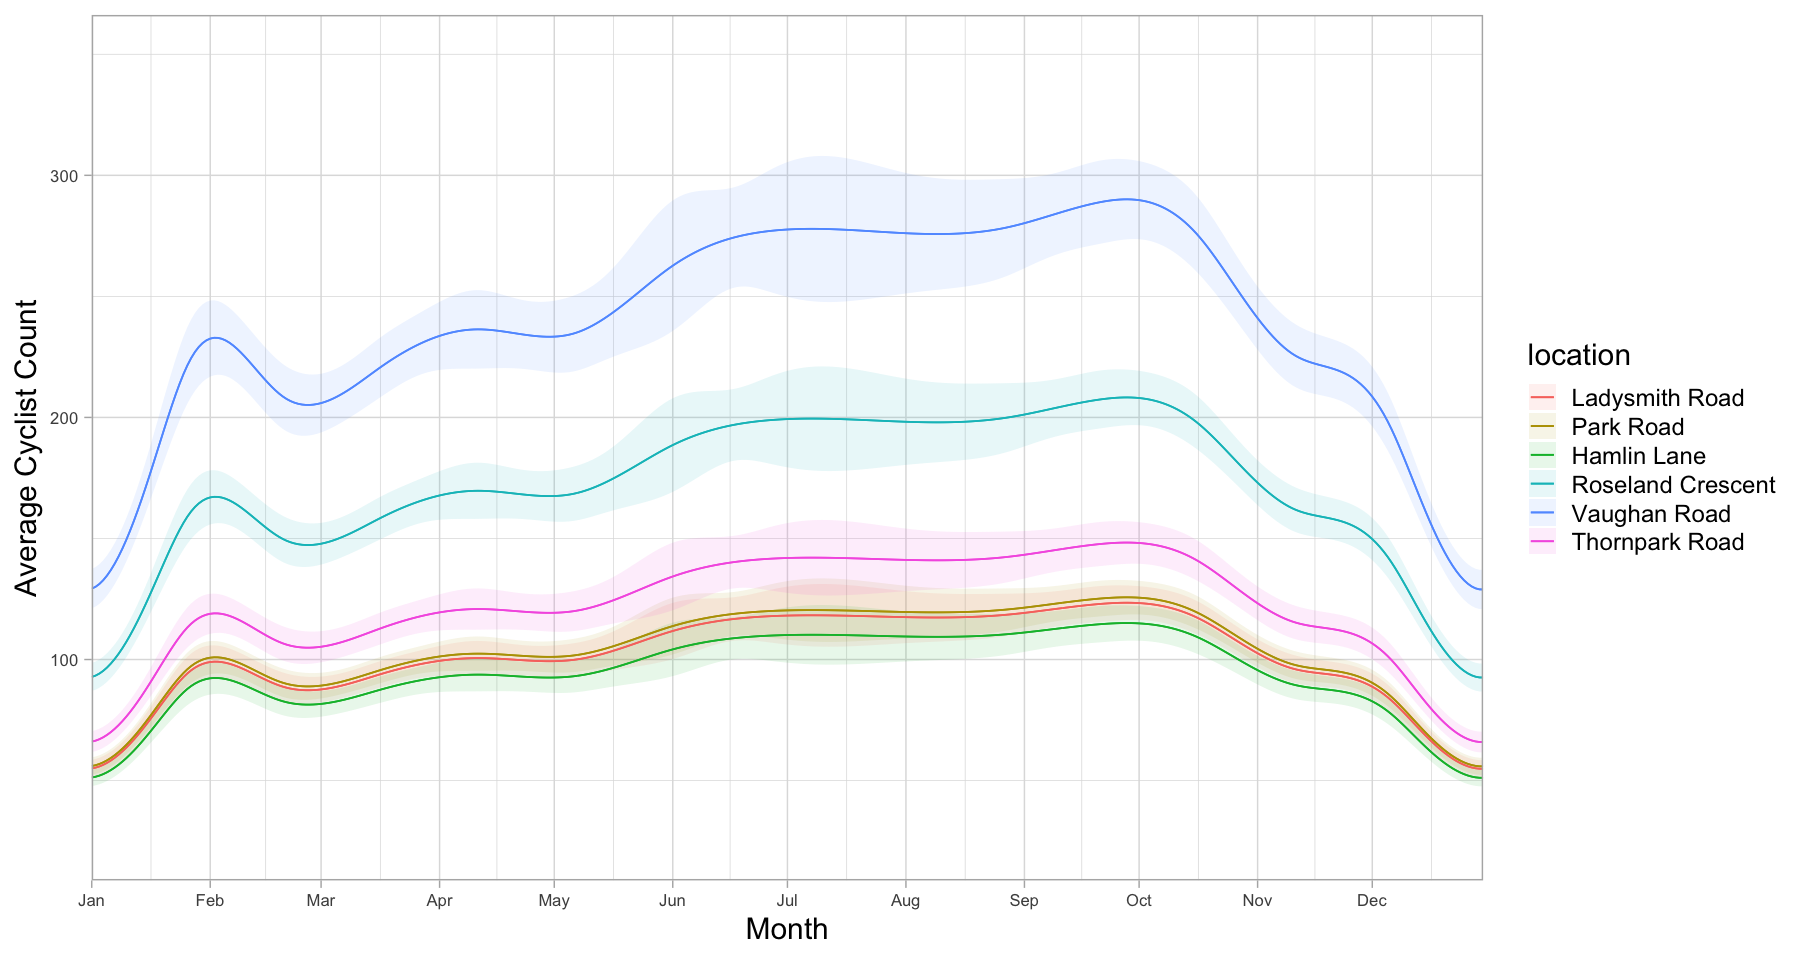

In [283]:
plot_predictions(nb.m5, condition = list(doy=seq(1,365), 'location'), type = 'response', newdata='mean', vcov = TRUE) +
scale_y_continuous(limits = c(25, 350)) +
labs(x = "Month", y = "Average Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10)) +
scale_x_continuous(breaks=yday(breaks),
        labels=month(breaks, label=TRUE),
        limits = c(1, 365), expand=c(0,0))

## Model Residuals

Plot of unexplained variation in data

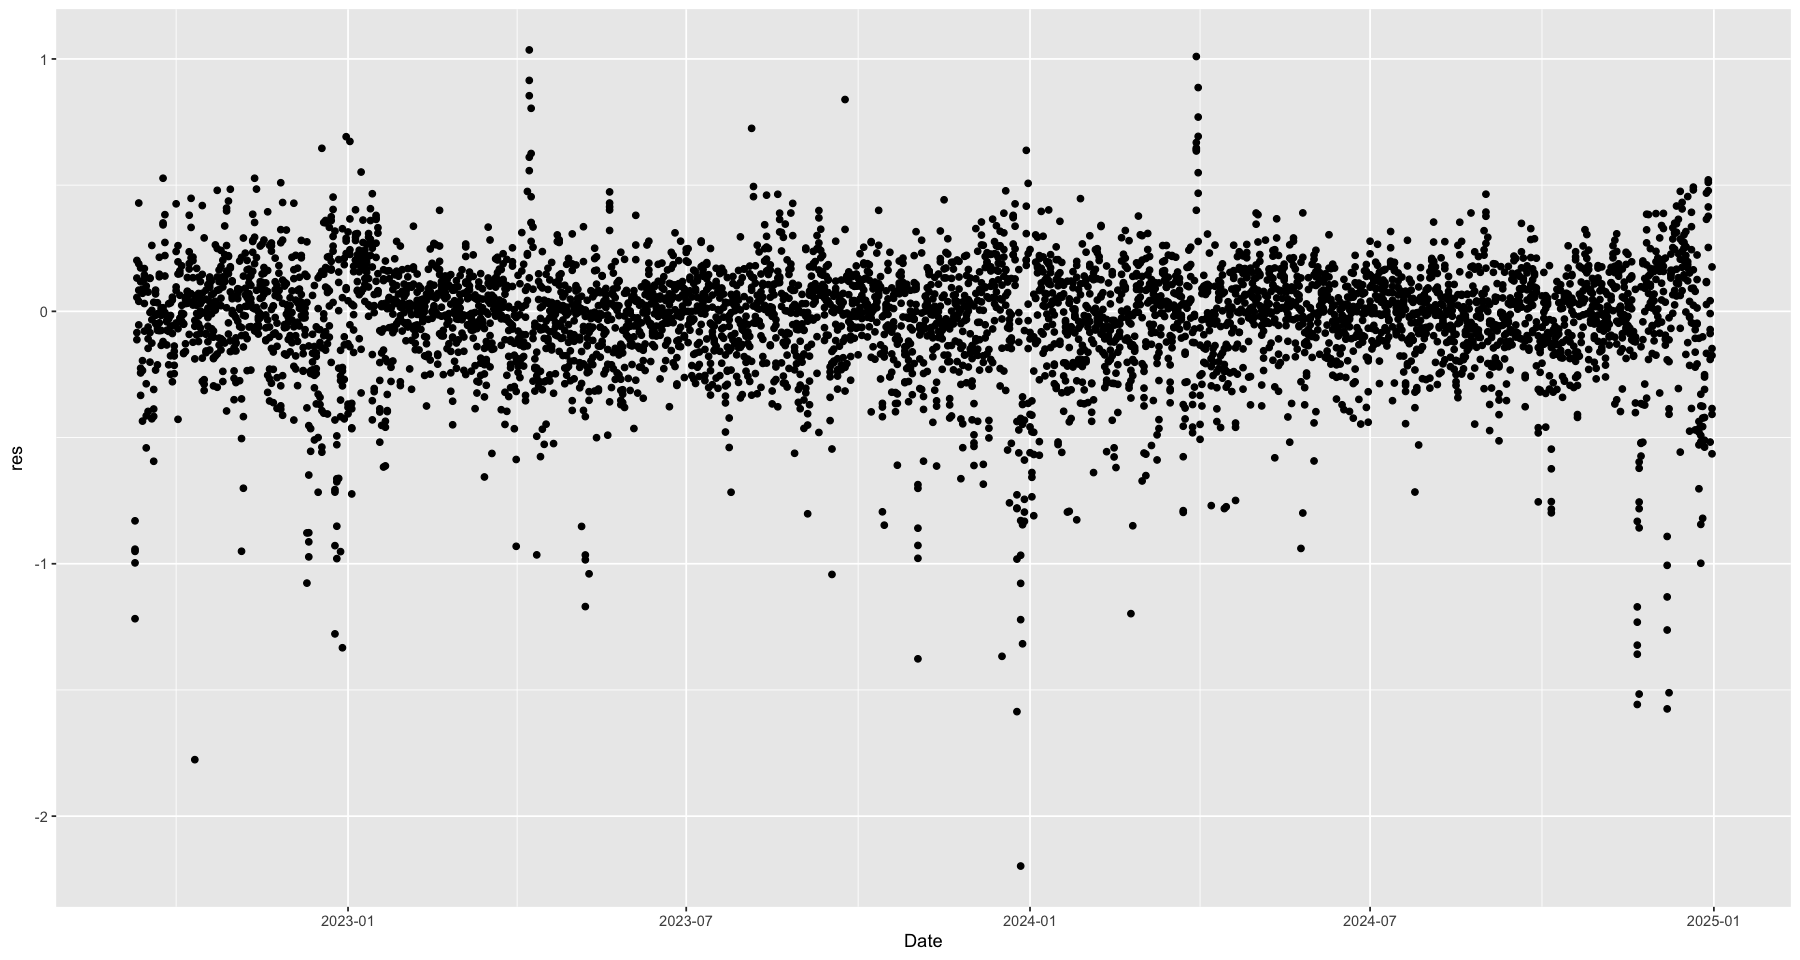

In [195]:
ggplot(data=df2 %>% mutate(res = nb.m5$residuals), aes(x=Date, y=res)) + geom_point()

In [322]:
df %>% filter(mode == 'Cyclist') %>% mutate(res = nb.m1$residuals)

Date       weekday doy ast.3bool ast.2bool location       school.hol year
1    2022-09-10 6       253 Before    No        Ladysmith Road 0          0   
2    2022-09-11 7       254 Before    No        Ladysmith Road 0          0   
3    2022-09-12 1       255 Before    No        Ladysmith Road 0          0   
4    2022-09-13 2       256 Before    No        Ladysmith Road 0          0   
5    2022-09-14 3       257 Before    No        Ladysmith Road 0          0   
6    2022-09-15 4       258 Before    No        Ladysmith Road 0          0   
7    2022-09-16 5       259 Before    No        Ladysmith Road 0          0   
8    2022-09-17 6       260 Before    No        Ladysmith Road 0          0   
9    2022-09-18 7       261 Before    No        Ladysmith Road 0          0   
10   2022-09-19 1       262 Before    No        Ladysmith Road 0          0   
11   2022-09-20 2       263 Before    No        Ladysmith Road 0          0   
12   2022-09-21 3       264 Before    No        Ladysmith Road 0          0   
13   2022-09-22 4       265 Before    No        Ladysmith Road 0          0   
14   2022-09-23 5       266 Before    No        Ladysmith Road 0          0   
15   2022-09-24 6       267 Before    No        Ladysmith Road 0          0   
16   2022-09-25 7       268 Before    No        Ladysmith Road 0          0   
17   2022-09-26 1       269 Before    No        Ladysmith Road 0          0   
18   2022-09-27 2       270 Before    No        Ladysmith Road 0          0   
19   2022-09-28 3       271 Before    No        Ladysmith Road 0          0   
20   2022-09-29 4       272 Before    No        Ladysmith Road 0          0   
21   2022-09-30 5       273 Before    No        Ladysmith Road 0          0   
22   2022-10-01 6       274 Before    No        Ladysmith Road 0          0   
23   2022-10-02 7       275 Before    No        Ladysmith Road 0          0   
24   2022-10-03 1       276 Before    No        Ladysmith Road 0          0   
25   2022-10-04 2       277 Before    No        Ladysmith Road 0          0   
26   2022-10-05 3       278 Before    No        Ladysmith Road 0          0   
27   2022-10-06 4       279 Before    No        Ladysmith Road 0          0   
28   2022-10-07 5       280 Before    No        Ladysmith Road 0          0   
29   2022-10-08 6       281 Before    No        Ladysmith Road 0          0   
30   2022-10-09 7       282 Before    No        Ladysmith Road 0          0   
⋮    ⋮          ⋮       ⋮   ⋮         ⋮         ⋮              ⋮          ⋮   
3718 2024-12-02 1       337 After     No        Thornpark Road 0          2   
3719 2024-12-03 2       338 After     No        Thornpark Road 0          2   
3720 2024-12-04 3       339 After     No        Thornpark Road 0          2   
3721 2024-12-05 4       340 After     No        Thornpark Road 0          2   
3722 2024-12-06 5       341 After     No        Thornpark Road 0          2   
3723 2024-12-07 6       342 After     No        Thornpark Road 0          2   
3724 2024-12-08 7       343 After     No        Thornpark Road 0          2   
3725 2024-12-09 1       344 After     No        Thornpark Road 0          2   
3726 2024-12-10 2       345 After     No        Thornpark Road 0          2   
3727 2024-12-11 3       346 After     No        Thornpark Road 0          2   
3728 2024-12-12 4       347 After     No        Thornpark Road 0          2   
3729 2024-12-13 5       348 After     No        Thornpark Road 0          2   
3730 2024-12-14 6       349 After     No        Thornpark Road 0          2   
3731 2024-12-15 7       350 After     No        Thornpark Road 0          2   
3732 2024-12-16 1       351 After     No        Thornpark Road 0          2   
3733 2024-12-17 2       352 After     No        Thornpark Road 0          2   
3734 2024-12-18 3       353 After     No        Thornpark Road 0          2   
3735 2024-12-19 4       354 After     No        Thornpark Road 0          2   
3736 2024-12-20 5       355 After     No        Thornpa

In [95]:
avg_predictions(nb.m3, variables = 'weekday', 
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), weekday=seq(1,7), rain=0),
type = 'response', vcov=TRUE)

weekday estimate  std.error statistic p.value       s.value  conf.low 
1 1       115.80309 4.291760  26.98266  2.361723e-160 530.2687 107.39139
2 2       122.15717 4.492121  27.19365  7.721177e-163 538.5255 113.35277
3 4       124.16167 4.563401  27.20815  5.202225e-163 539.0952 115.21757
4 6        54.86254 2.119495  25.88473  9.895803e-148 488.3385  50.70841
5 7        48.41092 1.903433  25.43347  1.075646e-142 471.6086  44.68026
  conf.high
1 124.21478
2 130.96156
3 133.10577
4  59.01668
5  52.14158

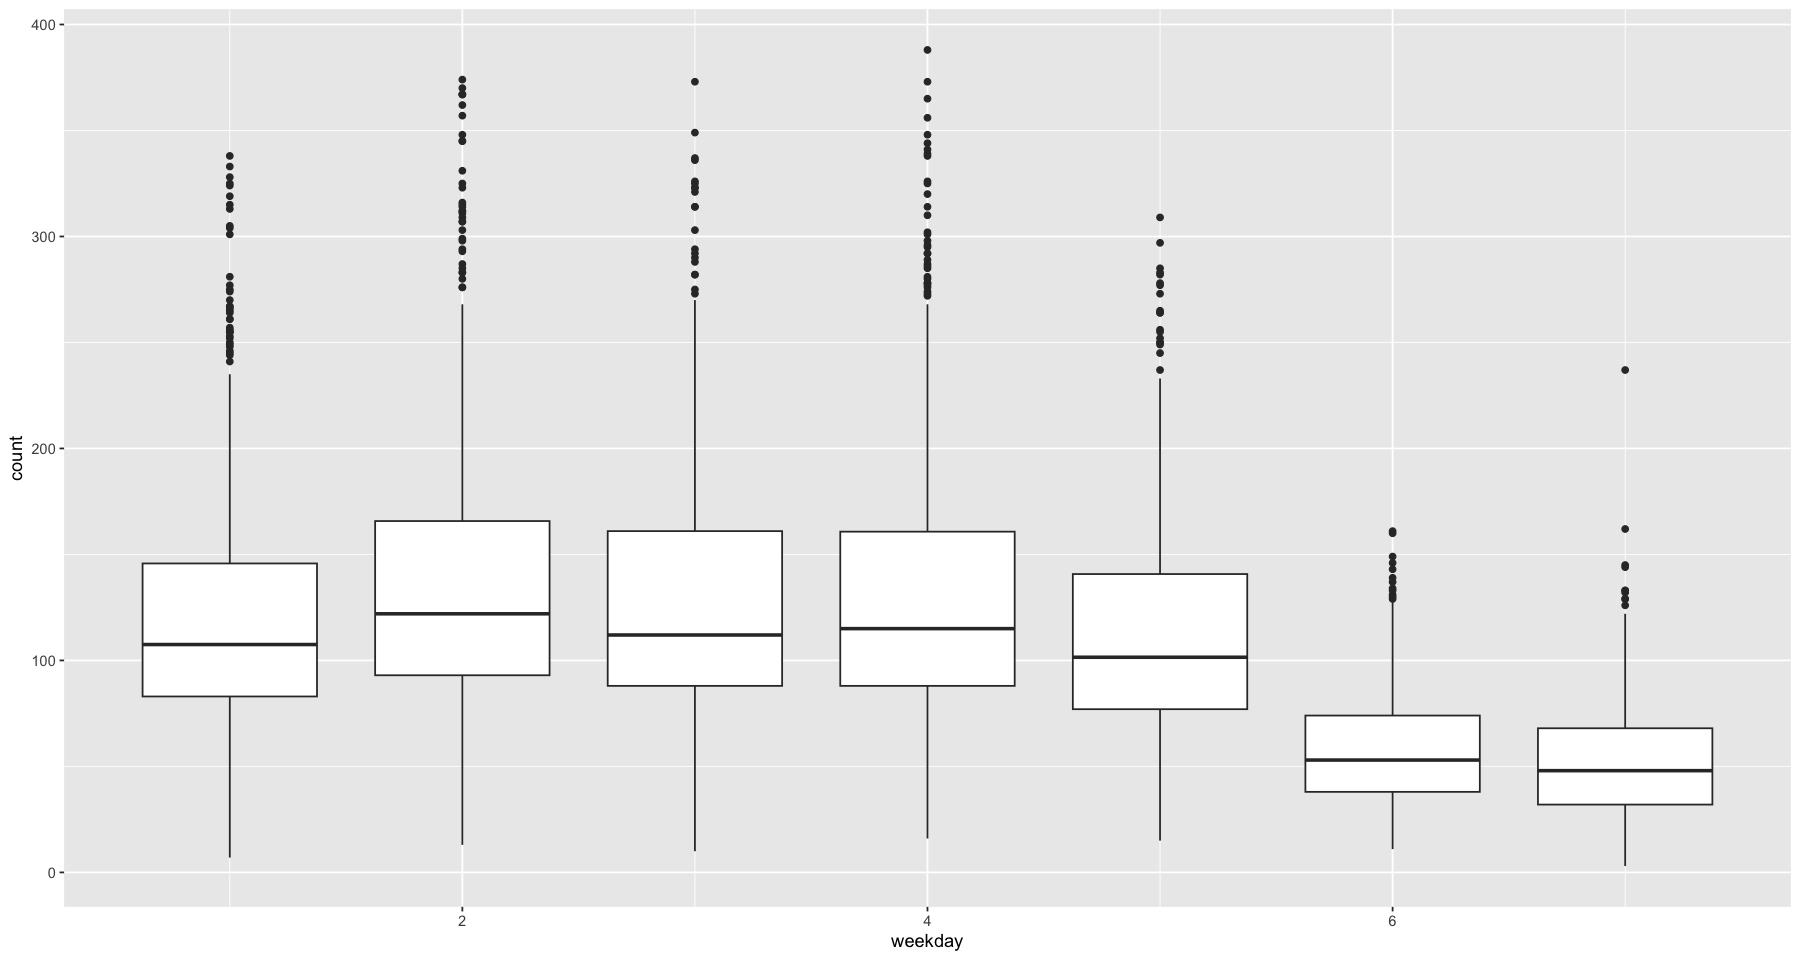

In [99]:
ggplot(data=df %>% filter(mode == "Cyclist"), aes(x=weekday, y=count, group=weekday)) + geom_boxplot()

In [311]:
nb.m2 <- gamm(count ~ s(location, bs="re") + 
                s(weekday, location, bs='fs', xt=list(bs="ts"), k=7) + 
                s(ast.3bool, bs='re') + 
                s(school.hol, bs='re')+
                s(doy, bs = 'cc', k=12)+
                s(rain, k=5, bs='ts'),
            data = df %>% filter(mode=='Cyclist'),
            family = nb, method='REML',
            correlation = corARMA(form = ~ doy, p=3))

ERROR: Error in `[<-`(`*tmp*`, object$rank + i, object$rank + i, value = 1): subscript out of bounds


In [170]:
summary(nb.m2$gam)


Family: negative binomial 
Link function: log 

Formula:
count ~ s(location, bs = "re") + s(weekday, location, bs = "fs", 
    xt = list(bs = "cr"), k = 7) + s(ast.bool, bs = "re") + s(school.hol, 
    bs = "re") + s(doy, bs = "cc", k = 12)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.433      0.206   21.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df      F p-value    
s(location)          0.001342      5   0.00  <2e-16 ***
s(weekday,location) 39.223788     41 225.78  <2e-16 ***
s(ast.bool)          1.971890      2  57.28  <2e-16 ***
s(school.hol)        0.998070      1 785.50  <2e-16 ***
s(doy)               9.682227     10 469.50  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.84   
  Scale est. = 0.068613  n = 3747

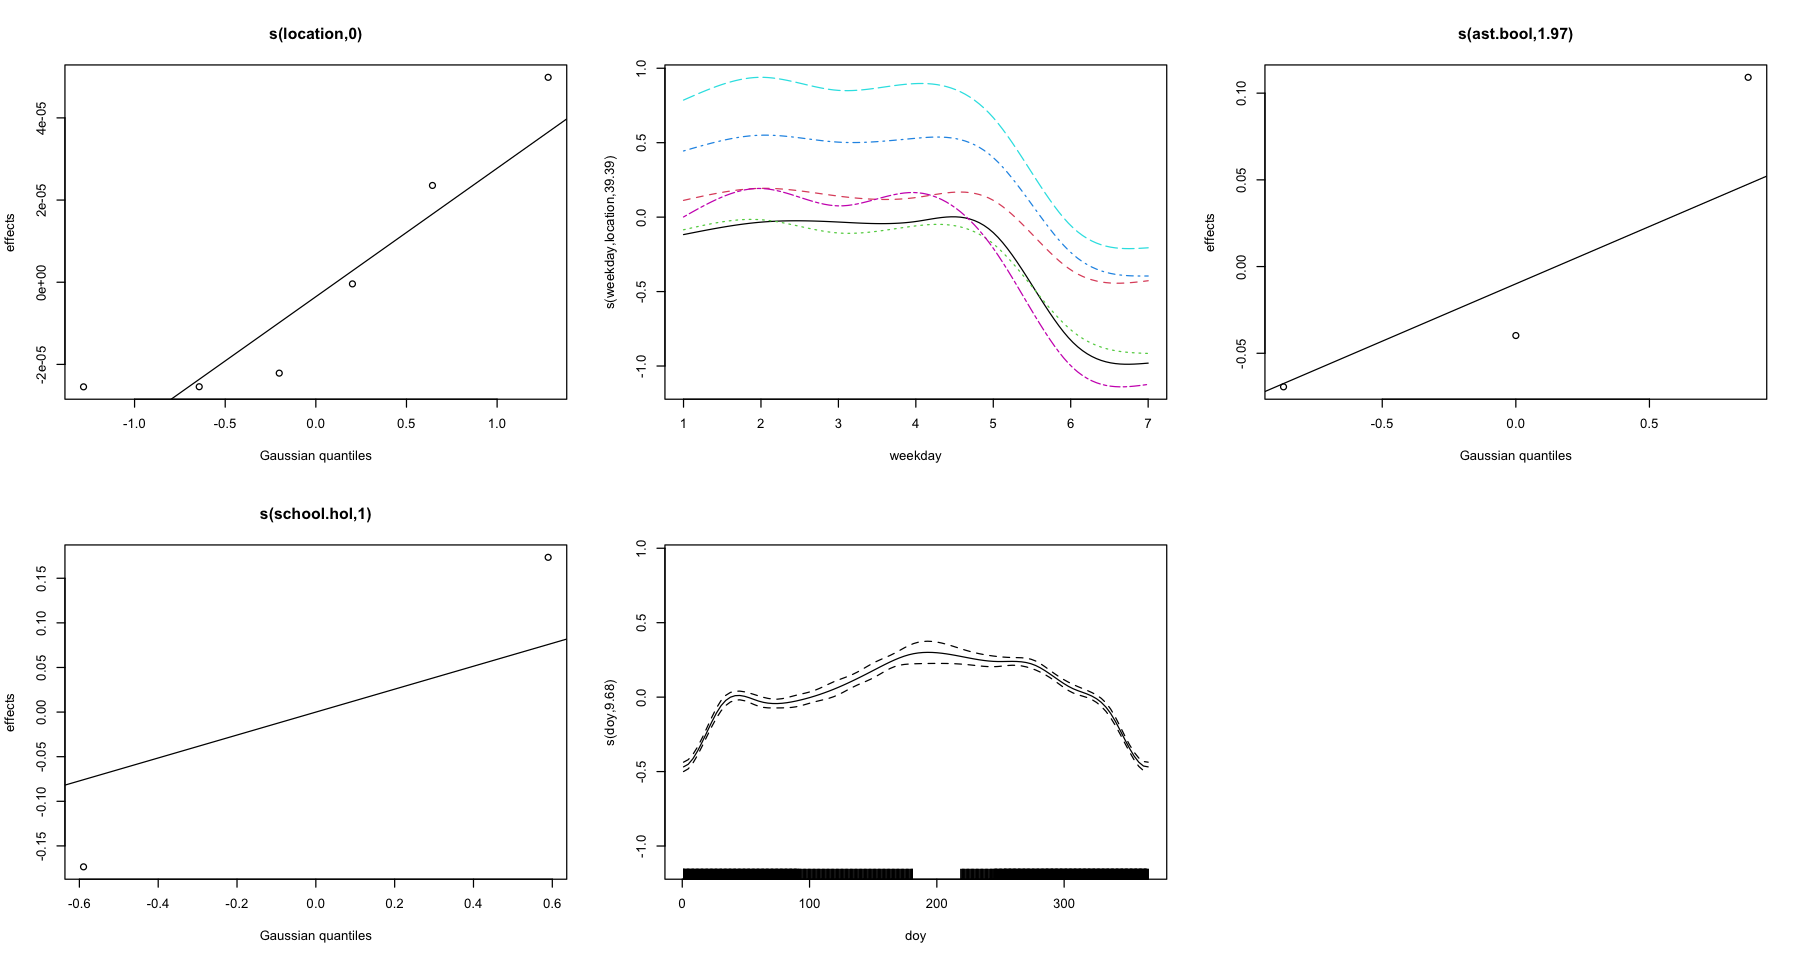

In [148]:
par(bg = "white")
plot(nb.m2$gam, pages=1)

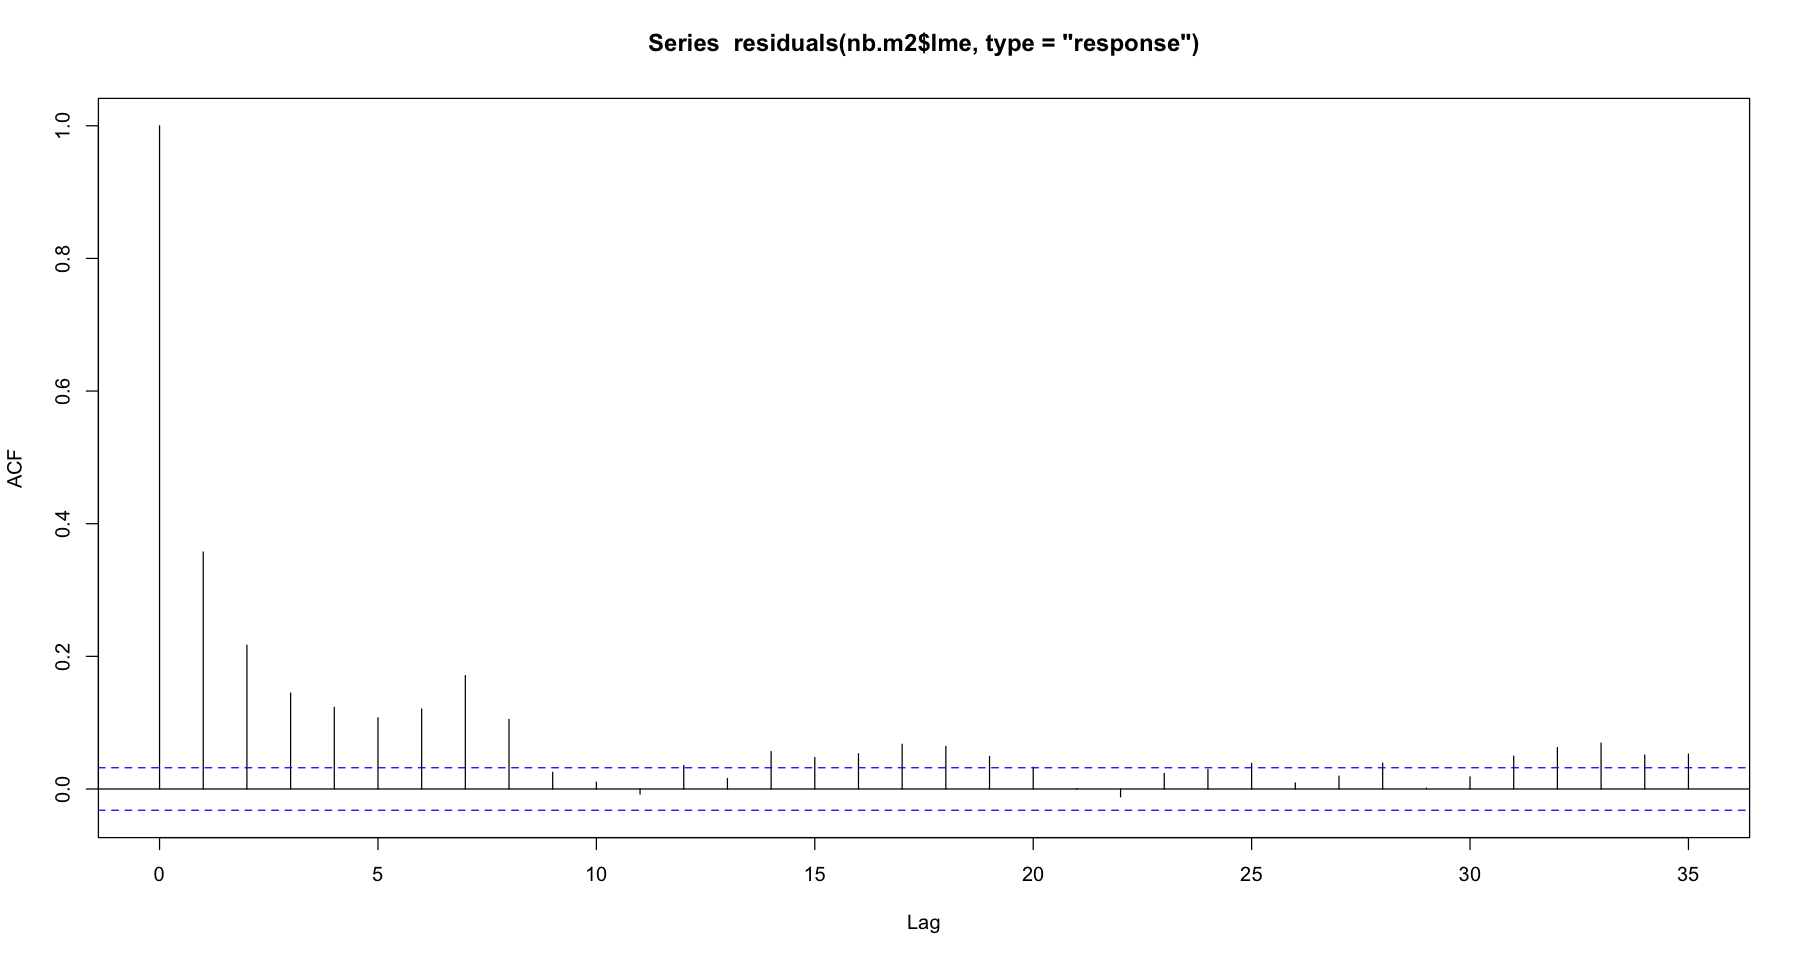

In [163]:
par(bg = "white")
acf(residuals(nb.m2$lme, type = 'response'))

In [160]:
coef(nb.m2$lme$modelStruct$corStruct, unconstrained = F)

Phi1        Phi2        Phi3 
0.192692077 0.039500336 0.006151291